<a href="https://colab.research.google.com/github/eitellauria/Applied_Causal_Inference_Course/blob/main/bambi_retention_last_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Freshmen_Retention (using bambi)

CHeck:

- https://bambinos.github.io/bambi/notebooks/logistic_regression.html



In [ ]:
!pip install -q arviz>=0.12.0 formulae>=0.5.3 graphviz pandas>=1.0.0 pymc>=5.18.0
!pip install -q bambi
!pip install -q fancyimpute


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import arviz as az
import bambi as bmb
import pymc as pm

import seaborn as sns
import time
from datetime import datetime
import jax


from sklearn import preprocessing

from fancyimpute import KNN

import warnings
# Suppress specific warning
warnings.filterwarnings("ignore", category=DeprecationWarning)

SEED = 666
az.style.use("arviz-darkgrid")

In [ ]:
#import psutil
#import multiprocessing

# Get total memory in bytes and convert to GB
#total_memory_gb = psutil.virtual_memory().total / (1024**3)

# Get the number of available CPU cores
#cpu_cores = multiprocessing.cpu_count()

p#rint(f"Total memory: {total_memory_gb:.2f} GB")
p#rint(f"Number of CPU cores: {cpu_cores}")

Total memory: 83.48 GB
Number of CPU cores: 12


In [ ]:
#import jax
#import jax.numpy as jnp

#try:
    # Attempt a simple JAX operation on the GPU
#    key = jax.random.PRNGKey(0)
#    x = jnp.ones((1, 1))
#    y = jax.jit(lambda x: x @ x.T)(x)
#    # If the above operation succeeds on the GPU, print the device info
#    print("GPU is available. Device info:")
#    print(jax.devices())
#except RuntimeError as e:
    # If a runtime error occurs (likely due to no GPU being found), print an error message
#    print("GPU is not available. JAX is running on CPU.")
#    print(f"Error: {e}")

GPU is available. Device info:
[CudaDevice(id=0)]


In [ ]:
bmb.inference_methods.names

{'pymc': {'mcmc': ['mcmc'], 'vi': ['vi']}, 'bayeux': {'mcmc': []}}

## Helper Functions

In [ ]:
def select_period(df, year_list):
    # Filter the DataFrame based on whether TERM_CODE_IR is in the year_list
    return df[df['TERM_CODE_IR'].isin(year_list)]

#---------------------------------------------------------------------------
# Function to process features
def process_features(df, missing_threshold=0.5):

    cols = ['TERM_CODE_IR', 'AGE', 'EFC', 'pellEligable',
            'pell_amount', 'studentOfColor', 'gender', 'isFirstGeneration',
            'distanceFromHome',
            'isHEOP',
            #'VisaType','OtherCitizenship', 'USPermRes',
            'USCitizen',
            'HSRankPercent',
            'ClassRank', 'ClassSize', 'HSGPA', 'HSMatriculationRate',
            'NumAPCourses', 'NumHonorsCourses', 'NumIBHCourses', 'NumIBSCourses',
            'applicantTypeCode',
            #'levelOfInterest',
            'WaitListYN', 'isMeritScholarship',
            'UnmetNeed', 'hasLoans', 'DepositDate',
            'initialHousingAssignment','initialHousingRelocationCount',
            'SchoolCode', 'MAJOR',
            'isDivisionI', 'isLSP', 'isHonorsProgram',
            #'isFFE', 'isFDE',
            'isCampusWorkStudy',
            #'GPA_EffectiveEndOfFall',
            'GPA_EffectiveEndOfAcademicYear',
            #'gradeFYS', 'isFullTimeFYS', 'isTakenInFallFYS','countTakenFYS',
            #'GradeCountFall', 'FailCountFall', 'WithdrawCountFall',
            #'GradeCountSpring', 'FailCountSpring', 'WithdrawCountSpring',
            'isAcademicProbation', 'conductCaseCount', 'isSelfDevelopment',
            'isCareerPlanning', 'tutoringClassCount',
            'isReferredForTutoring', 'isGreekLife',
            'percentCreditsFullTimeFall', 'isClubAthlete', 'ISDEANSLIST',
            'didNotReturnNextFallIR']

    # Select the columns
    df = df[cols].copy()

    # Drop columns with all missing values
    df = df.dropna(axis='columns', how="all")

    #Drop columns with SchoolCode="CT"
    df = df.query('SchoolCode!="CT"').copy()


    # Drop columns with all missing values
    df = df[df['gender'] != 'N'].copy()



    # Drop columns with missing value percentage above the threshold
    threshold_count = len(df) * missing_threshold
    df = df.dropna(thresh=threshold_count, axis=1)

    # Identify and drop columns that are constant
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]
    df = df.drop(constant_columns, axis=1)

    # Identify and drop numeric columns twith near-zero variance
    #numeric_cols = df.select_dtypes(include=[np.number]).columns
    #near_zero_variance = df[numeric_cols].apply(lambda x: np.var(x) < 1e-5)
    #numeric_predictors = [col for col, nzv in near_zero_variance.items() if not nzv]
    #non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
    #cols = numeric_predictors + list(non_numeric_cols)
    #df = df[cols]

    #categorical_vars = ['pellEligable','gender','applicantTypeCode', 'SchoolCode','MAJOR']
    #df.loc[:, categorical_vars] = df[categorical_vars].astype('category')

    def calculate_days(row):
        # Extract the year from TERM_CODE_IR and subtract 1
        year = int(str(row['TERM_CODE_IR'])[:4]) - 1
        # Create startdepositdate as October 1 of the previous year
        startdepositdate = datetime(year, 10, 1)
        # Calculate the difference in days
        days_difference = (row['DepositDate'] - startdepositdate).days
        return days_difference

    # Apply the function to the DataFrame
    df['DepositDaysDifference'] = df.apply(calculate_days, axis=1)

    # Drop the DepositDate column
    df = df.drop('DepositDate', axis=1)

    return df

#---------------------------------------------------------------------------------------------------------------------------------------------
# Impute the dataframe with the original values (no previous encoding)
from fancyimpute import KNN
from sklearn.impute import SimpleImputer
import contextlib
import io

def knn_impute_dataframe(df, k=5):
    # Separate categorical and numeric columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Impute categorical columns using SimpleImputer with the most frequent strategy
    for col in categorical_cols:
        imputer = SimpleImputer(strategy='most_frequent')
        df[col] = imputer.fit_transform(df[[col]]).ravel()

    # Impute numeric columns using KNN
    print("Imputing rows...")
    knn_imputer = KNN(k=k)

    # Suppress output
    f = io.StringIO()
    with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
        df[numeric_cols] = knn_imputer.fit_transform(df[numeric_cols])

    print("Imputation completed successfully!")
    return df
#----------------------------------------------------------------------------------------------------------------------------------------------
def cast_type(df):
    cols = {
        'TERM_CODE_IR': 'int32',
        'AGE': 'float64',
        'EFC': 'float64',
        'pellEligable': 'category',
        'pell_amount': 'float64',
        'studentOfColor': 'category',
        'gender': 'category',
        'isFirstGeneration': 'category',
        'distanceFromHome': 'float64',
        'isHEOP': 'category',
        'USCitizen': 'category',
        'HSRankPercent': 'int32',
        'HSGPA': 'float64',
        'NumAPCourses': 'float64',
        'NumHonorsCourses': 'float64',
        'NumIBHCourses': 'float64',
        'NumIBSCourses': 'float64',
        'applicantTypeCode': 'category',
        'WaitListYN': 'category',
        'isMeritScholarship': 'category',
        'UnmetNeed': 'float64',
        'hasLoans': 'category',
        'initialHousingAssignment': 'category',
        'initialHousingRelocationCount': 'float64',
        'SchoolCode': 'category',
        'MAJOR': 'category',
        'isDivisionI': 'category',
        'isLSP': 'category',
        'isHonorsProgram': 'category',
        'isFFE': 'category',
        'isFDE': 'category',
        'isCampusWorkStudy': 'category',
        'GPA_EffectiveEndOfAcademicYear': 'float64',
        'isAcademicProbation': 'category',
        'isSelfDevelopment': 'category',
        'isCareerPlanning': 'category',
        'tutoringClassCount': 'float64',
        'percentCreditsFullTimeFall': 'float64',
        'ISDEANSLIST': 'category',
        'didNotReturnNextFallIR': 'int32',
        'DepositDaysDifference': 'float64'
    }

    for col, dtype in cols.items():
        if col in df.columns:
            df[col] = df[col].astype(dtype)

    return df
#-----------------------------------------------------------------------------------------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def scale_float_columns(df):
    # Create a MinMaxScaler object
    scaler = StandardScaler()

    # Select only float columns
    target = 'didNotReturnNextFallIR'
    float_columns = df.select_dtypes(include=['float64']).columns
    float_columns = [col for col in float_columns if col != target]

    # Scale vars
    df[float_columns] = scaler.fit_transform(df[float_columns])

    return df

#-----------------------------------------------------------------------------------------------------------------------------------------------
from scipy.stats import zscore

def remove_outliers(df):
    # Identify numerical features (excluding the dependent variable). The are previously scaled to z-scores
    numerical_features = df.select_dtypes(include=['float64']).columns.tolist()

    # Removing outliers based on z-score
    df_cleaned = df[(df[numerical_features].abs() < 3).all(axis=1)]  # Keep only rows where all absolute values are less than 3

    # Print the number of rows removed
    print(f"Number of rows before removing outliers: {df.shape[0]}")
    print(f"Number of rows after removing outliers: {df_cleaned.shape[0]}")
    print(f"Number of rows removed: {df.shape[0] - df_cleaned.shape[0]}")

    return df_cleaned

def remove_outliers_iqr(df, multiplier=2.5):
    # Identify numerical features (excluding the dependent variable)
    numerical_features = df.select_dtypes(include=['float64']).columns.tolist()

    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each numerical feature
    Q1 = df[numerical_features].quantile(0.25)
    Q3 = df[numerical_features].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier detection criteria
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Removing outliers based on IQR
    df_cleaned = df[~((df[numerical_features] < lower_bound) | (df[numerical_features] > upper_bound)).any(axis=1)]

    # Print the number of rows removed
    print(f"Number of rows before removing outliers: {df.shape[0]}")
    print(f"Number of rows after removing outliers: {df_cleaned.shape[0]}")
    print(f"Number of rows removed: {df.shape[0] - df_cleaned.shape[0]}")

    return df_cleaned
#-----------------------------------------------------------------------------------------------------------------------------------------------
def create_dummies(df):
    df_dummies = pd.get_dummies(df, drop_first=True)
    # Convert only boolean columns to integers
    bool_cols = df_dummies.select_dtypes(include=['bool']).columns
    df_dummies[bool_cols] = df_dummies[bool_cols].astype(int)
    return df_dummies

#-----------------------------------------------------------------------------------------------------------------------------------------------
def split_train_test_old(df,first_year_train, last_year_train, first_year_test, last_year_test):
    df['AcademicYear'] = df['TERM_CODE_IR'].astype(str).str[:4]
    df['AcademicYear'] = df['AcademicYear'].astype('category')
    dfr = df.query('@first_year_train <= TERM_CODE_IR <= @last_year_train').drop('TERM_CODE_IR', axis=1)
    dft = df.query('@first_year_test <= TERM_CODE_IR <= @last_year_test').drop('TERM_CODE_IR', axis=1)
    return dfr, dft

#---------------------------------------------------------------------------------------------------------------------------------------------
def split_train_test(df,first_year, last_year):
    from sklearn.model_selection import train_test_split
    df['AcademicYear'] = df['TERM_CODE_IR'].astype(str).str[:4]
    df['AcademicYear'] = df['AcademicYear'].astype('category')
    df = df.query('@first_year <= TERM_CODE_IR <= @last_year').drop('TERM_CODE_IR', axis=1)

    # Create empty lists to store train-test indices
    train_indices, test_indices = [], []

    # Loop through each academic year and stratify the split
    for year in df["AcademicYear"].unique():
       df_year = df[df["AcademicYear"] == year]
       train_idx, test_idx = train_test_split(df_year.index, stratify=df_year["didNotReturnNextFallIR"], test_size=0.2, random_state=42)
       train_indices.extend(train_idx)
       test_indices.extend(test_idx)

    # Subset the data based on selected indices
    dfr = df.loc[train_indices]
    dft = df.loc[test_indices]
    return dfr, dft

#----------------------------------------------------------------------------------------------------------------------------------------------
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

def check_multicollinearity(df):
    predictors = 'AGE + EFC + pell_amount + studentOfColor + isFirstGeneration + distanceFromHome + USCitizen +  HSGPA + NumAPCourses + NumHonorsCourses + NumIBHCourses + NumIBSCourses + WaitListYN + isMeritScholarship + UnmetNeed + hasLoans + initialHousingRelocationCount + isDivisionI + isLSP + isHonorsProgram' +\
                 '+ isCampusWorkStudy + GPA_EffectiveEndOfAcademicYear + isAcademicProbation + isSelfDevelopment + isCareerPlanning + tutoringClassCount + percentCreditsFullTimeFall + ISDEANSLIST + DepositDaysDifference'
                  # '+ isFFE + isFDE
    # Create design matrices
    formula = f'didNotReturnNextFallIR ~ {predictors}'
    y, X = dmatrices(formula, df, return_type='dataframe')

    # Calculate VIF for each predictor variable
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data

# Example usage
# Assuming df is your DataFrame and it contains the column 'didNotReturnNextFallIR'
# df = pd.read_csv('your_data.csv')
# vif_results = check_multicollinearity(df)
# print(vif_results)

#----------------------------------------------------------------------------------------------------------------------------------------------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)

# Function to evaluate performance and plot results
def evaluate_performance(y_true, y_pred, probs, dataset_type='Test'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    specificity = recall_score(y_true, y_pred, pos_label=0)
    roc = roc_auc_score(y_true, probs)

    print(f"\n{dataset_type} Set Performance Metrics:")
    print(f"Accuracy.........: {accuracy * 100.0:.4f}")
    print(f"Precision........: {precision * 100:.4f}")
    print(f"Recall...........: {recall * 100:.4f}")
    print(f"FP Rate..........: {(1 - specificity) * 100:.4f}")
    print(f"ROC AUC (probs)..: {roc :.4f}")
    print(f"F1 measure.......: {f1 :.4f}")

    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion matrix.:\n {cm}")

    plt.figure(figsize=(12, 6))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f'{dataset_type} Set Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}, F1 = {f1:.2f}')
    plt.title(f'{dataset_type} Set ROC Curve')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.tight_layout()
    plt.show()

# Evaluate performance for test set
#evaluate_performance(y_test, y_test_pred, probs_test, dataset_type='Test')

# Evaluate performance for train set
#evaluate_performance(y_train, y_train_pred, probs_train, dataset_type='Train')

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
import re

def calculate_rope_percentage(posterior_samples, rope_min, rope_max):
    """
    Calculate the percentage of posterior samples that fall within the ROPE.

    Parameters:
    - posterior_samples: Array of posterior samples for a parameter.
    - rope_min: Minimum value of the ROPE.
    - rope_max: Maximum value of the ROPE.

    Returns:
    - Percentage of posterior samples within the ROPE.
    """
    within_rope = np.logical_and(posterior_samples >= rope_min, posterior_samples <= rope_max)
    return 100 * np.mean(within_rope)

def compute_hdi_rope_overlap(hdi_min, hdi_max, rope_min, rope_max):
    """
    Computes the percentage overlap between the HDI and ROPE.

    Parameters:
    - hdi_min: Lower bound of the HDI.
    - hdi_max: Upper bound of the HDI.
    - rope_min: Minimum value of the ROPE.
    - rope_max: Maximum value of the ROPE.

    Returns:
    - Percentage overlap between the HDI and ROPE.
    """
    overlap_min = max(hdi_min, rope_min)
    overlap_max = min(hdi_max, rope_max)
    if overlap_min < overlap_max:
        return 100 * (overlap_max - overlap_min) / (hdi_max - hdi_min)
    return 0.0

def filter_var_names(idata, exclude_patterns, include_intercept=True):
    """
    Filter variable names from an ArviZ InferenceData object based on exclusion patterns.

    Parameters:
    - idata: InferenceData object from ArviZ.
    - exclude_patterns: List of regex patterns to exclude.
    - include_intercept: Boolean indicating whether to include 'Intercept' in the result.

    Returns:
    - List of filtered variable names.
    """
    # Extract variable names from the posterior group
    all_var_names = list(idata.posterior.data_vars)

    # Compile the exclude patterns into regex objects
    exclude_regex = [re.compile(pattern) for pattern in exclude_patterns]

    # Filter variable names based on exclude patterns
    filtered_var_names = [
        var for var in all_var_names
        if not any(regex.match(var) for regex in exclude_regex)
    ]

    # Optionally include the intercept
    if include_intercept and 'Intercept' in all_var_names and 'Intercept' not in filtered_var_names:
        filtered_var_names.append('Intercept')

    return filtered_var_names

def add_rope_info(idata, var_names, default_rope_min, default_rope_max, ropes=None):
    """
    Adds columns to the ArviZ summary DataFrame indicating the percentage of
    posterior samples within the ROPE and the percentage overlap between the 95% HDI and the ROPE.

    Parameters:
    - idata: InferenceData object from ArviZ.
    - var_names: List of variable names to include in the summary.
    - default_rope_min: Default minimum value of the ROPE.
    - default_rope_max: Default maximum value of the ROPE.
    - ropes: Optional list of tuples specifying (rope_min, rope_max) for each variable.

    Returns:
    - Updated DataFrame with additional columns for the percentage of posterior samples within the ROPE
      and the percentage overlap between the HDI and ROPE.
    """
    summary_df = az.summary(idata, var_names=var_names, hdi_prob=0.95)  # should typically be 0.95 or 0.89
    rope_percentages = []
    hdi_rope_overlaps = []

    for var in summary_df.index:
        base_var = var.split('[')[0]
        if ropes and base_var in var_names:
            rope_idx = var_names.index(base_var)
            rope_min, rope_max = ropes[rope_idx]
        else:
            rope_min, rope_max = default_rope_min, default_rope_max

        # Handle dummy variables
        try:
            posterior_samples = idata.posterior[var].values.flatten()
        except KeyError:
            base_var = var.split('[')[0]  # For dummy variables
            posterior_samples = idata.posterior[base_var].values.flatten()

        rope_percentage = calculate_rope_percentage(posterior_samples, rope_min, rope_max)
        rope_percentages.append(rope_percentage)

        hdi_min = summary_df.loc[var, 'hdi_2.5%']
        hdi_max = summary_df.loc[var, 'hdi_97.5%']
        hdi_rope_overlap = compute_hdi_rope_overlap(hdi_min, hdi_max, rope_min, rope_max)
        hdi_rope_overlaps.append(hdi_rope_overlap)

    summary_df['% posterior samples within ROPE'] = rope_percentages
    summary_df['%  95% HDI within ROPE'] = hdi_rope_overlaps

    # Move Intercept to the top
    if 'Intercept' in summary_df.index:
        intercept_row = summary_df.loc['Intercept']
        summary_df = summary_df.drop('Intercept')
        summary_df = pd.concat([pd.DataFrame([intercept_row]), summary_df])


    return summary_df


## Main

In [ ]:
df = pd.read_excel('https://foxweb.marist.edu/users/jf4n/Research/Bayes/UnitofAnalysis4.xlsx')
#df = select_period(df, [201340,201440,201540])
df = select_period(df, [201240,201340,201440,201540,201640,201740,201840,202140, 202240])
#df = df.query("SchoolCode=='SI'")
df = process_features(df);
df = knn_impute_dataframe(df, k=5);
df = cast_type(df);
df = scale_float_columns(df);
#df = remove_outliers(df);

Imputing rows...
Imputation completed successfully!


In [ ]:
#df.info()

In [ ]:
#dfr, dft = split_train_test(df,first_year_train=201240, last_year_train=202240, first_year_test=201540, last_year_test=201540)

## Stratified Train-Test Split Within Each Academic Year

In [ ]:
dfr, dft = split_train_test(df,first_year=201240, last_year=202240)

# Verify split proportions
print("Train shape:", dfr.shape)
print("Test shape:", dft.shape)
print("Train attrition rate:", dfr["didNotReturnNextFallIR"].mean())
print("Test attrition rate:", dft["didNotReturnNextFallIR"].mean())


Train shape: (8735, 39)
Test shape: (2186, 39)
Train attrition rate: 0.10555237550085861
Test attrition rate: 0.10612991765782251


In [ ]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8735 entries, 1064 to 12878
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   AGE                             8735 non-null   float64 
 1   EFC                             8735 non-null   float64 
 2   pellEligable                    8735 non-null   category
 3   pell_amount                     8735 non-null   float64 
 4   studentOfColor                  8735 non-null   category
 5   gender                          8735 non-null   category
 6   isFirstGeneration               8735 non-null   category
 7   distanceFromHome                8735 non-null   float64 
 8   isHEOP                          8735 non-null   category
 9   USCitizen                       8735 non-null   category
 10  HSRankPercent                   8735 non-null   int32   
 11  HSGPA                           8735 non-null   float64 
 12  NumAPCourses         

In [ ]:
dfr['didNotReturnNextFallIR'].value_counts()
#dfr['SchoolCode'].query.value_counts()
#dfr.query('SchoolCode=="CT"')

didNotReturnNextFallIR
0    7813
1     922
Name: count, dtype: int64

In [ ]:
dfr.groupby('SchoolCode').mean('GPA_EffectiveEndOfAcademicYear')
#dfr['SchoolCode'].query.value_counts()
#dfr.query('SchoolCode=="CT"')

/tmp/ipykernel_2471/4089970073.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfr.groupby('SchoolCode').mean('GPA_EffectiveEndOfAcademicYear')


,AGE,EFC,pell_amount,distanceFromHome,HSRankPercent,HSGPA,NumAPCourses,NumHonorsCourses,NumIBHCourses,NumIBSCourses,UnmetNeed,initialHousingRelocationCount,GPA_EffectiveEndOfAcademicYear,tutoringClassCount,percentCreditsFullTimeFall,didNotReturnNextFallIR,DepositDaysDifference
SchoolCode,,,,,,,,,,,,,,,,,
CC,0.015356,-0.051403,0.020904,-0.080725,0.002398,0.128007,0.244544,0.154500,-0.058433,-0.004491,-0.007685,0.017627,-0.014649,-0.057339,0.457201,0.081535,0.115637
CO,0.036584,0.052977,-0.095972,0.042592,0.000000,0.001066,-0.089832,-0.038974,-0.023974,-0.023310,0.038456,0.029315,0.140022,-0.064572,-0.032276,0.099585,-0.111503
LA,0.036443,-0.006932,0.011288,-0.003335,0.000000,-0.133551,-0.033840,-0.090823,0.053579,0.020974,-0.045226,-0.039219,-0.038848,-0.012317,-0.158560,0.133894,0.003602
SB,-0.114814,0.028086,0.069162,-0.015414,0.000880,0.003886,-0.020250,-0.004367,-0.005112,-0.000106,-0.001320,0.094199,0.112207,-0.031903,-0.167297,0.109938,-0.103859
SI,-0.089492,-0.060824,0.107717,0.056651,0.006608,0.343642,0.227984,0.180316,0.041989,0.036363,-0.031525,-0.127737,-0.247560,0.200593,0.454728,0.120044,0.108218
SM,0.042851,-0.026048,-0.039259,-0.042645,0.000000,-0.112253,-0.074679,-0.045451,-0.017023,-0.012049,-0.047829,0.017747,-0.053080,0.028684,-0.115194,0.086751,0.046217


/tmp/ipykernel_2471/292352069.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['AcademicYear', 'didNotReturnNextFallIR']).size().unstack()
/tmp/ipykernel_2471/292352069.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.5)


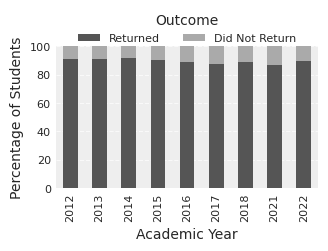

In [ ]:
# Group data by SchoolCode and didNotReturnNextFallIR, then normalize to percentages
grouped_data = df.groupby(['AcademicYear', 'didNotReturnNextFallIR']).size().unstack()
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100  # Convert counts to percentages

# Set a color palette that is more academic (e.g., grayscale)
colors = sns.color_palette("gray", 2)

# Plotting the data
fig, ax = plt.subplots(figsize=(3.5, 3))  # Adjust the figsize for a one-column layout
grouped_data.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Adding titles and labels
ax.set_xlabel('Academic Year', fontsize=10)
ax.set_ylabel('Percentage of Students', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, 100)  # Set y-axis to range from 0% to 100%

# Adjust the legend to be above the plot and make it more compact
ax.legend(['Returned', 'Did Not Return'], title='Outcome', fontsize=8, title_fontsize='10', loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False)


# Ensure everything fits well
plt.tight_layout(pad=1.5)

# Save the plot as a high-resolution image suitable for academic papers
plt.savefig('./attrition_by_academic_year.png', dpi=300)

# Show the plot
plt.show()


In [ ]:
#dfr.info()

In [ ]:
pd.set_option('display.max_columns', None)
dfr.head()

,AGE,EFC,pellEligable,pell_amount,studentOfColor,gender,isFirstGeneration,distanceFromHome,isHEOP,USCitizen,HSRankPercent,HSGPA,NumAPCourses,NumHonorsCourses,NumIBHCourses,NumIBSCourses,applicantTypeCode,WaitListYN,isMeritScholarship,UnmetNeed,hasLoans,initialHousingAssignment,initialHousingRelocationCount,SchoolCode,MAJOR,isDivisionI,isLSP,isHonorsProgram,isCampusWorkStudy,GPA_EffectiveEndOfAcademicYear,isAcademicProbation,isSelfDevelopment,isCareerPlanning,tutoringClassCount,percentCreditsFullTimeFall,ISDEANSLIST,didNotReturnNextFallIR,DepositDaysDifference,AcademicYear
1064,0.140622,-0.338562,NO,-0.375860,0.0,F,0.0,-0.285814,0.0,1.0,0,-1.121358,0.189585,0.957904,-0.144538,-0.159865,RD,1.0,0.0,0.131331,1.0,CH,0.052428,SB,PSYS,0.0,0.0,0.0,0.0,0.057403,0.0,0.0,0.0,-0.209702,-1.997142,0.0,0,1.163319,2012
602,0.140622,0.153171,NO,-0.375860,0.0,F,0.0,-0.275574,0.0,1.0,0,0.800308,2.148389,-1.009906,-0.144538,-0.159865,EA,0.0,1.0,-0.818315,0.0,LE,0.052428,SM,ACCT,0.0,0.0,0.0,0.0,-0.347050,0.0,0.0,0.0,-0.209702,-0.337237,0.0,0,-0.539887,2012
754,0.140622,-0.567430,YES,2.698949,0.0,F,0.0,-0.288740,0.0,1.0,0,0.373271,-0.593937,1.351467,-0.144538,-0.159865,RD,0.0,0.0,1.322176,1.0,LE,0.052428,CO,COM,0.0,0.0,0.0,0.0,0.049573,0.0,0.0,1.0,-0.209702,-0.254460,0.0,0,0.420896,2012
580,0.140622,0.026670,NO,-0.375860,0.0,F,0.0,-0.385295,0.0,1.0,0,1.013826,0.581346,-0.222782,-0.144538,-0.159865,EA,0.0,1.0,-0.818315,0.0,CH,-2.586108,SI,MEDT,0.0,0.0,0.0,0.0,0.885836,0.0,0.0,0.0,-0.209702,0.053123,0.0,0,0.377224,2012
626,0.140622,-0.343774,NO,-0.375860,0.0,M,0.0,-0.272648,0.0,1.0,0,0.159753,1.364868,0.170780,-0.144538,-0.159865,EA,0.0,1.0,0.652345,1.0,LE,0.052428,SM,BAD,0.0,0.0,0.0,1.0,0.850131,0.0,0.0,0.0,-0.209702,-1.997142,1.0,0,0.617420,2012


In [ ]:
dfr.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,8735.0,0.003081,0.999641,-4.038240,0.140622,0.140622,0.140622,10.587777
EFC,8735.0,-0.001508,0.983261,-0.568557,-0.566303,-0.257130,0.142633,13.519988
pell_amount,8735.0,-0.007877,0.990762,-0.375860,-0.375860,-0.375860,-0.375860,4.442645
distanceFromHome,8735.0,-0.003216,0.995591,-0.385295,-0.312148,-0.285814,-0.218518,7.488337
HSRankPercent,8735.0,0.001030,0.032084,0.000000,0.000000,0.000000,0.000000,1.000000
HSGPA,8735.0,-0.003020,0.987625,-19.056906,-0.694321,-0.053766,0.586790,3.576047
NumAPCourses,8735.0,-0.001071,1.005454,-0.985698,-0.985698,-0.202176,0.581346,8.808324
NumHonorsCourses,8735.0,-0.005208,1.001133,-1.009906,-0.813125,-0.222782,0.564342,4.499964
NumIBHCourses,8735.0,-0.000591,0.986451,-0.144538,-0.144538,-0.144538,-0.144538,17.469651
NumIBSCourses,8735.0,-0.000788,0.993632,-0.159865,-0.159865,-0.159865,-0.159865,14.880886


In [ ]:
vif_results = check_multicollinearity(dfr)
print(vif_results)

                          Variable        VIF
0                        Intercept  48.966246
1            studentOfColor[T.1.0]   1.198207
2         isFirstGeneration[T.1.0]   1.115698
3                 USCitizen[T.1.0]   1.198552
4                WaitListYN[T.1.0]   1.119445
5        isMeritScholarship[T.1.0]   1.681623
6                  hasLoans[T.1.0]   1.374174
7               isDivisionI[T.1.0]   1.131415
8                     isLSP[T.1.0]   1.193668
9           isHonorsProgram[T.1.0]   1.222525
10        isCampusWorkStudy[T.1.0]   1.224412
11      isAcademicProbation[T.1.0]   1.579779
12        isSelfDevelopment[T.1.0]   2.279888
13         isCareerPlanning[T.1.0]   2.261706
14              ISDEANSLIST[T.1.0]   1.734901
15                             AGE   1.068539
16                             EFC   1.176201
17                     pell_amount   1.393645
18                distanceFromHome   1.045068
19                           HSGPA   1.752326
20                    NumAPCourses

Interpreting the Variance Inflation Factor (VIF) Results

Your VIF results look quite good overall, except for one major issue:

Most predictors have a VIF < 5, meaning multicollinearity is not a major concern.

The intercept has a very high VIF (~49), which suggests strong collinearity with other predictors.

A few predictors have VIF between 2.5 - 3.0, which may warrant attention.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


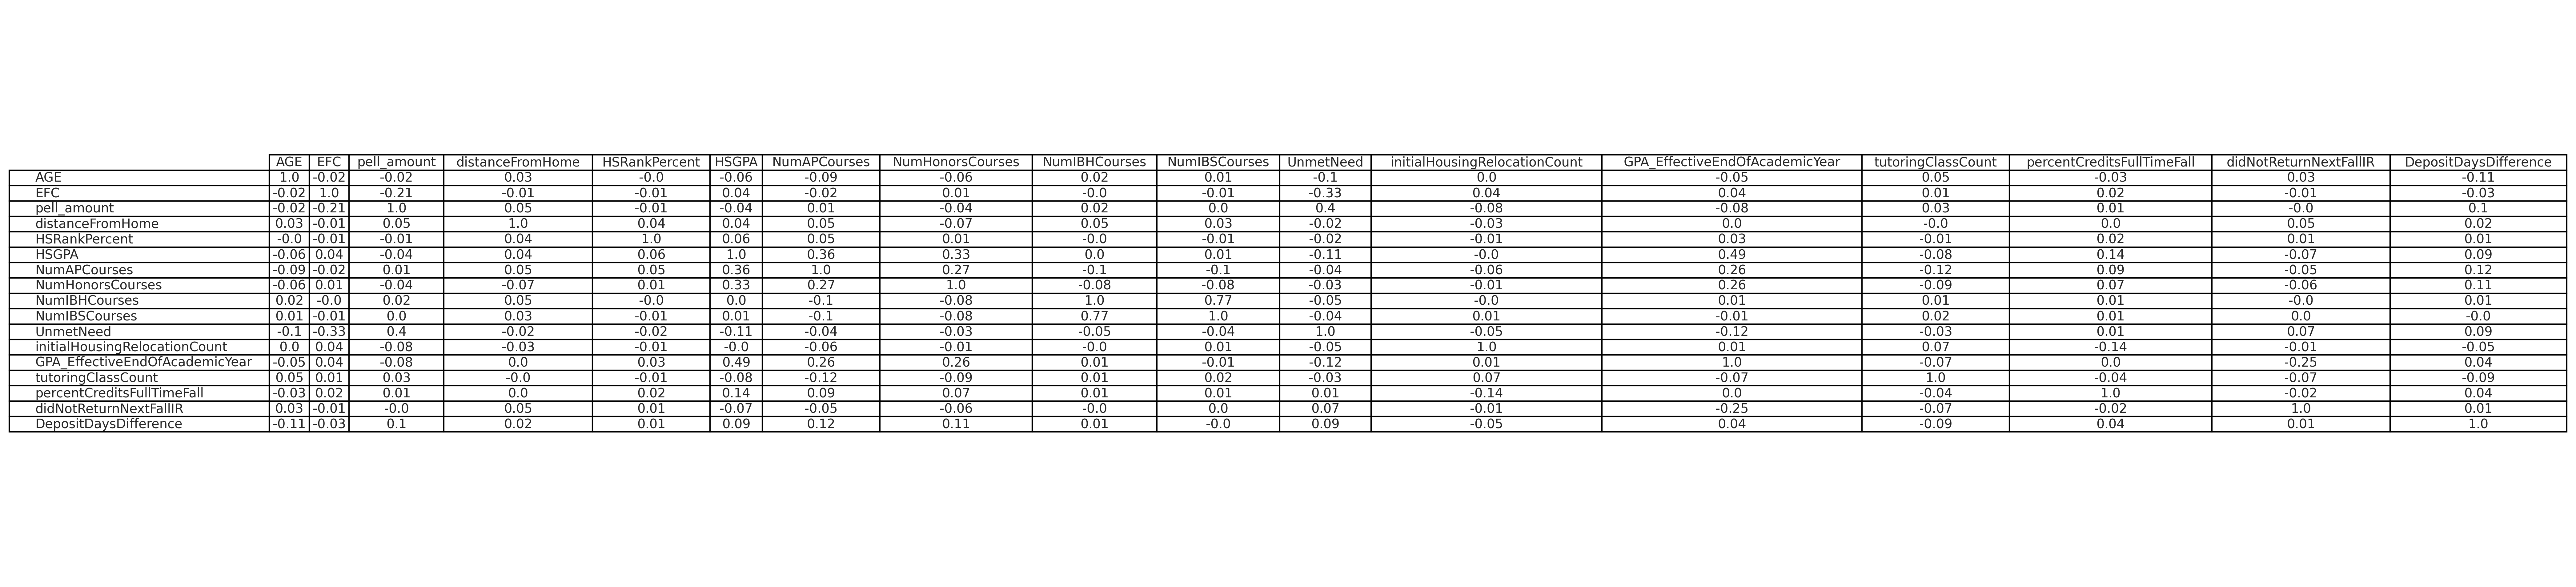

In [ ]:
# Select only numeric columns
numeric_df = dfr.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Compute the correlation matrix
numeric_df = dfr.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr().round(2)

# Create a table visualization
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=correlation_matrix.values,
                 colLabels=correlation_matrix.columns,
                 rowLabels=correlation_matrix.index,
                 cellLoc='center',
                 loc='center')

# Set table style for readability
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(correlation_matrix.columns))))

# Save the table as a high-resolution image
#plt.savefig("correlation_matrix_table.pdf", format="pdf", bbox_inches="tight")
#plt.savefig("correlation_matrix_table.png", dpi=300, bbox_inches="tight")

# Show the table
plt.show()

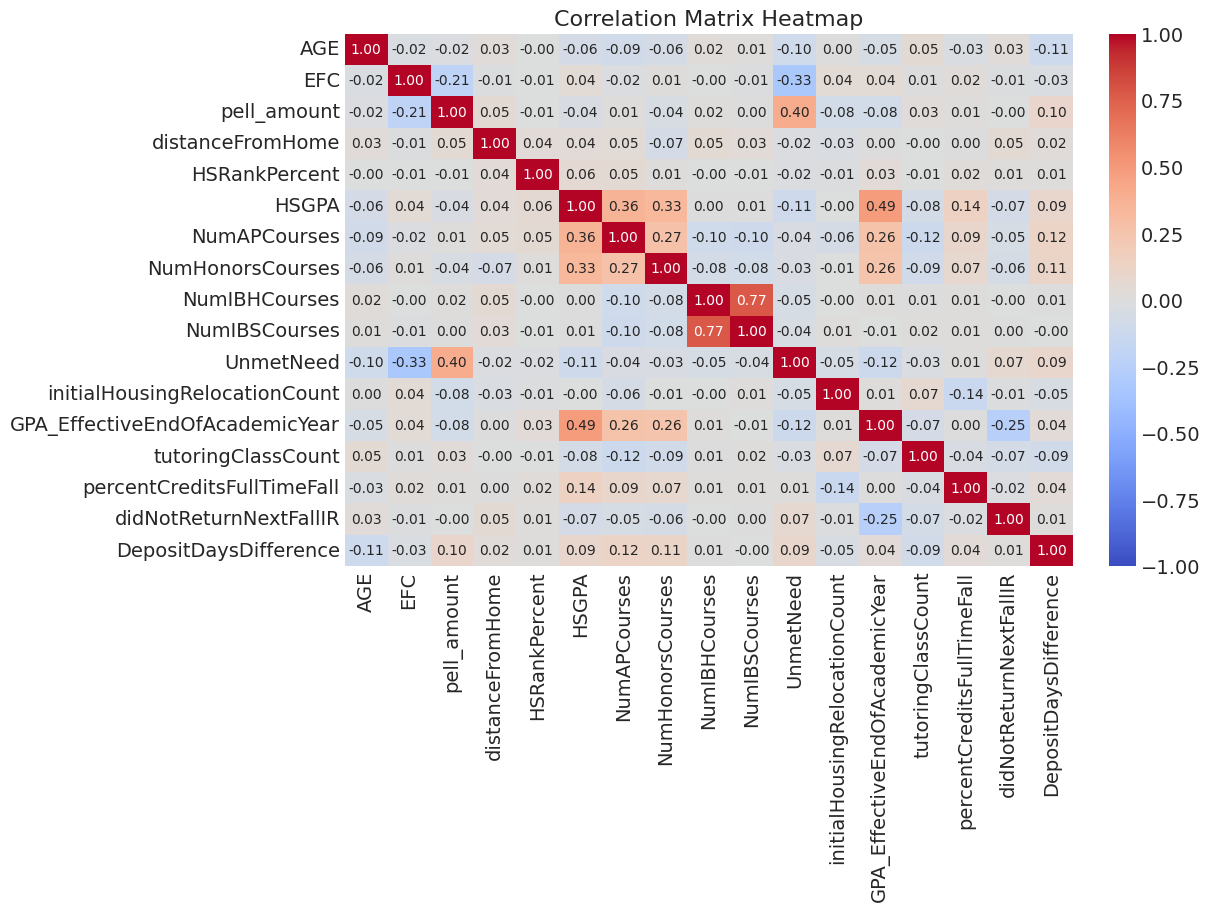

In [ ]:
# Correlation matrix
numeric_df = dfr.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.xticks(rotation=90)  # Rotate x-axis labels vertically
plt.yticks(rotation=0)   # Keep y-axis labels horizontal
plt.title('Correlation Matrix Heatmap')
plt.show()


Key Collinearity Issues
- High Correlation (r > 0.75) Between:

 - NumIBHCourses and NumIBSCourses (r = 0.77)

   These two are highly correlated and likely capture redundant information.

   Suggestion: Drop one of them (choose the one with weaker predictive power in your model).

 - GPA_EffectiveEndOfAcademicYear and HSGPA (r = 0.49)

   Not extremely high, but still significant.

   Since GPA_EffectiveEndOfAcademicYear is time-dependent and HSGPA is pre-college, they may be measuring different concepts.

   Suggestion: Keep both unless further testing shows redundancy.

- Moderate Collinearity (r ≈ 0.4 - 0.6)
 - UnmetNeed and pell_amount (r = 0.40)

   Not severe, but these variables could overlap conceptually.

   Suggestion: Keep both unless model diagnostics show issues.

 - EFC and UnmetNeed (r = -0.33)

   This negative correlation makes sense, as students with higher EFC (Expected Family Contribution) have lower UnmetNeed.

   Suggestion: Likely okay to keep both if their effects remain distinct.


In [ ]:
dfr['isSelfDevelopment'].value_counts()

isSelfDevelopment
0.0    7890
1.0     845
Name: count, dtype: int64

In [ ]:
dfr

,AGE,EFC,pellEligable,pell_amount,studentOfColor,gender,isFirstGeneration,distanceFromHome,isHEOP,USCitizen,HSRankPercent,HSGPA,NumAPCourses,NumHonorsCourses,NumIBHCourses,NumIBSCourses,applicantTypeCode,WaitListYN,isMeritScholarship,UnmetNeed,hasLoans,initialHousingAssignment,initialHousingRelocationCount,SchoolCode,MAJOR,isDivisionI,isLSP,isHonorsProgram,isCampusWorkStudy,GPA_EffectiveEndOfAcademicYear,isAcademicProbation,isSelfDevelopment,isCareerPlanning,tutoringClassCount,percentCreditsFullTimeFall,ISDEANSLIST,didNotReturnNextFallIR,DepositDaysDifference,AcademicYear
1064,0.140622,-0.338562,NO,-0.375860,0.0,F,0.0,-0.285814,0.0,1.0,0,-1.121358,0.189585,0.957904,-0.144538,-0.159865,RD,1.0,0.0,0.131331,1.0,CH,0.052428,SB,PSYS,0.0,0.0,0.0,0.0,0.057403,0.0,0.0,0.0,-0.209702,-1.997142,0.0,0,1.163319,2012
602,0.140622,0.153171,NO,-0.375860,0.0,F,0.0,-0.275574,0.0,1.0,0,0.800308,2.148389,-1.009906,-0.144538,-0.159865,EA,0.0,1.0,-0.818315,0.0,LE,0.052428,SM,ACCT,0.0,0.0,0.0,0.0,-0.347050,0.0,0.0,0.0,-0.209702,-0.337237,0.0,0,-0.539887,2012
754,0.140622,-0.567430,YES,2.698949,0.0,F,0.0,-0.288740,0.0,1.0,0,0.373271,-0.593937,1.351467,-0.144538,-0.159865,RD,0.0,0.0,1.322176,1.0,LE,0.052428,CO,COM,0.0,0.0,0.0,0.0,0.049573,0.0,0.0,1.0,-0.209702,-0.254460,0.0,0,0.420896,2012
580,0.140622,0.026670,NO,-0.375860,0.0,F,0.0,-0.385295,0.0,1.0,0,1.013826,0.581346,-0.222782,-0.144538,-0.159865,EA,0.0,1.0,-0.818315,0.0,CH,-2.586108,SI,MEDT,0.0,0.0,0.0,0.0,0.885836,0.0,0.0,0.0,-0.209702,0.053123,0.0,0,0.377224,2012
626,0.140622,-0.343774,NO,-0.375860,0.0,M,0.0,-0.272648,0.0,1.0,0,0.159753,1.364868,0.170780,-0.144538,-0.159865,EA,0.0,1.0,0.652345,1.0,LE,0.052428,SM,BAD,0.0,0.0,0.0,1.0,0.850131,0.0,0.0,0.0,-0.209702,-1.997142,1.0,0,0.617420,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12099,2.230053,-0.568557,NO,-0.375860,0.0,M,0.0,-0.320925,0.0,1.0,0,1.013826,-0.202176,-0.813125,-0.144538,-0.159865,RD,0.0,1.0,-0.818315,0.0,MR,0.052428,SM,BAD,0.0,0.0,0.0,0.0,0.416363,0.0,0.0,0.0,-0.209702,1.425921,0.0,0,-2.374109,2022
12905,-1.948809,-0.047055,NO,-0.375860,0.0,F,0.0,-0.338481,0.0,1.0,0,1.013826,-0.985698,0.367561,-0.144538,-0.159865,RD,0.0,1.0,0.252168,0.0,LE,0.052428,SM,BAD,0.0,0.0,0.0,0.0,0.644507,0.0,0.0,0.0,-0.209702,0.725799,1.0,0,0.595584,2022
12430,0.140622,3.685610,NO,-0.375860,0.0,F,0.0,-0.310685,0.0,1.0,0,0.586790,-0.202176,-0.222782,-0.144538,-0.159865,EA,0.0,1.0,-1.293583,0.0,MR,0.052428,SB,PCSE,0.0,0.0,0.0,0.0,0.691488,0.0,0.0,0.0,-0.209702,0.725799,1.0,0,-0.496215,2022
12544,0.140622,-0.568557,NO,-0.375860,0.0,F,0.0,-0.317999,0.0,1.0,0,2.081419,0.189585,0.957904,-0.144538,-0.159865,EA,0.0,1.0,-1.412401,0.0,CH,-2.586108,SM,BAD,0.0,0.0,0.0,0.0,1.223797,0.0,0.0,0.0,-0.209702,2.359563,1.0,0,-0.780083,2022


-----------------------
# Bayesian hierarchical Logistic regression

In [ ]:
# List of predictors

predictors = (
    #"AGE, "
    "EFC",
  ###"pellEligable, "
    "pell_amount",
    "studentOfColor",
    "gender",
    "isFirstGeneration",
    "distanceFromHome",
    "isHEOP",
    "USCitizen",
    #"HSRankPercent",
    "HSGPA",
    "NumAPCourses",
    "NumHonorsCourses",
   ##"NumIBHCourses",
   ##"NumIBSCourses",
   #"applicantTypeCode",
    "WaitListYN",
    #"isMeritScholarship",
    "UnmetNeed",
    "hasLoans",
   ### "initialHousingAssignment",
    "initialHousingRelocationCount",
    #"SchoolCode",
    #"MAJOR",
    "isDivisionI",
    #"isLSP",
    #"isHonorsProgram",
    #"isFFE",
    #"isFDE",
    "isCampusWorkStudy",
    "GPA_EffectiveEndOfAcademicYear",
   ##"isAcademicProbation",
   #"isSelfDevelopment"
   ##"isCareerPlanning",
    #"tutoringClassCount",
    "percentCreditsFullTimeFall",
   #"ISDEANSLIST"
   # "DepositDaysDifference"
)

predictors = (
    "EFC",
    "pell_amount",
    "studentOfColor",
    "gender",
    "isFirstGeneration",
    "distanceFromHome",
    #"isHEOP",
    #"USCitizen",
    "HSGPA",
    #"NumAPCourses",
    #"NumHonorsCourses",
    "WaitListYN",
    "UnmetNeed",
    "hasLoans",
    #"isDivisionI",
    "isCampusWorkStudy",
    "GPA_EffectiveEndOfAcademicYear"
)


# Create the formula string
#dependent_variable = "didNotReturnNextFallIR"
#predictors_string = " + ".join(predictors)
#predictors_string =predictors_string + " + " + "C(applicantTypeCode, levels=['EA', 'RD', 'EDI', 'EDII'])"
#predictors_string =predictors_string + " + applicantTypeCode

#formula = f"{dependent_variable} ~ {predictors_string}"
#formula



# Create the formula string
predictors_string = " + ".join(predictors)
dependent_variable = "didNotReturnNextFallIR"
group = "AcademicYear"
#group = "SchoolCode"
#group="applicantTypeCode"
predictors_string = " + ".join(predictors)

# Only Intercepts
formula = f"{dependent_variable} ~ {predictors_string} + (1 | SchoolCode)" # + (1 | AcademicYear)"
formula

'didNotReturnNextFallIR ~ EFC + pell_amount + studentOfColor + gender + isFirstGeneration + distanceFromHome + HSGPA + WaitListYN + UnmetNeed + hasLoans + isCampusWorkStudy + GPA_EffectiveEndOfAcademicYear + (1 | SchoolCode)'

In [ ]:
# Specify the Cauchy prior correctly with 'alpha' (location) and 'beta' (scale)
priors = {
    "Intercept": bmb.Prior("Cauchy", alpha=0, beta=2.5),
    "common": bmb.Prior("Cauchy", alpha=0, beta=2.5),  # Prior for all fixed effects
    "1|SchoolCode": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.5)),
    "1|AcademicYear": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.5))
}

# Create the model with specified priors
#model = bmb.Model(formula, dfr, family="bernoulli", priors=priors)

model = bmb.Model(formula, dfr, family="bernoulli")
print(model)

       Formula: didNotReturnNextFallIR ~ EFC + pell_amount + studentOfColor + gender + isFirstGeneration + distanceFromHome + isHEOP + USCitizen + HSGPA + NumAPCourses + NumHonorsCourses + WaitListYN + UnmetNeed + hasLoans + isDivisionI + isCampusWorkStudy + GPA_EffectiveEndOfAcademicYear + (1|SchoolCode) + (1|AcademicYear)
        Family: bernoulli
          Link: p = logit
  Observations: 2776
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 15.0633)
            EFC ~ Normal(mu: 0.0, sigma: 2.394)
            pell_amount ~ Normal(mu: 0.0, sigma: 2.4919)
            studentOfColor ~ Normal(mu: 0.0, sigma: 7.4327)
            gender ~ Normal(mu: 0.0, sigma: 5.0798)
            isFirstGeneration ~ Normal(mu: 0.0, sigma: 10.2054)
            distanceFromHome ~ Normal(mu: 0.0, sigma: 2.4989)
            isHEOP ~ Normal(mu: 0.0, sigma: 22.097)
            USCitizen ~ Normal(mu: 0.0, sigma: 14.6792)
            HSGPA ~ Normal(mu: 0.

## Intercept Prior in the Logit Model
**# 1. Why is the Intercept in the Logit Scal**e?
In logistic regression, the probability $p$ of an event occurring is modeled using t **logit functn**:

$$
\text{logit}(p) = \log \left( \frac{p}{1 - p} \right) = \beta_0 + \sum_{j=1}^{m} \betaj x_j
$$

where:
- $p$ is the probability of the outcome occurring (e.g., a student not returning next fall).
- $\beta_0$ (the intercept) reprents the **log-odds of attrition when all predicto are zero**.
- $\beta_j$ are the regression coefficients for predi

<br>ctors $x_j$.
Since the **logit function transforms probabilities into an unbounded real number scale**, the prior for the **intercept must also be defined .ls**e**.

---

## 2. Choosing a Normal Prior** for the Intercept

Given tat the dataset is *highly imbalanced** with an attrition rat ofapproximatel**10%**, we use a **Normal prr on he int{e}rcept**:

$$
\beta_0 \sm \m**al{N}(-2.2, 1)
$**$

### Why $\mu = -2.2$?

The **log-odds** are converted back to probability using te **sigmoid function**:

$$
p = \frc{1}

Since all numeric predictors are scaled using StandardScaler (mean=0, std=1), your priors should ideally:

Be centered around zero (✅ already done).
Have reasonable standard deviations that reflect expected effect sizes.
Prevent overly weak priors, which can cause sampling issues.

Key Issues in Current Prior Setup
Some priors have unnecessarily large standard deviations

Example: isHEOP ~ Normal(0, 22.097)
Since the predictors are z-scored, a standard deviation over 10+ is likely too large.
Weak priors allow extreme coefficient values, which may contribute to divergences.
Group-Level Effects (Random Effects) Lack Regularization

The priors for SchoolCode and AcademicYear (HalfNormal(15.68)) allow for very high variability, which may lead to unstable posteriors.
Binary Predictors (studentOfColor, gender, isFirstGeneration, etc.) Might Need Tighter Priors

If a binary predictor is scaled, a prior with too large a variance can make posterior inference unstable.
A Gaussian prior with a standard deviation between 2–3 is often better.
{1 + e^{-\text{logit}(p)}}
$$

assumes an overly wide distribution, implying a *
t attrition in a Bayesian hierarchical logistic regression framework.


       Formula: didNotReturnNextFallIR ~ EFC + pell_amount + studentOfColor + gender + isFirstGeneration + distanceFromHome + HSGPA + WaitListYN + UnmetNeed + hasLoans + isCampusWorkStudy + GPA_EffectiveEndOfAcademicYear + (1 | SchoolCode)
        Family: bernoulli
          Link: p = logit
  Observations: 8735
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: -2.2, sigma: 1.0)
            EFC ~ Normal(mu: 0.0, sigma: 1.5)
            pell_amount ~ Normal(mu: 0.0, sigma: 1.5)
            studentOfColor ~ Normal(mu: 0.0, sigma: 3.0)
            gender ~ Normal(mu: 0.0, sigma: 0.5)
            isFirstGeneration ~ Normal(mu: 0.0, sigma: 3.0)
            distanceFromHome ~ Normal(mu: 0.0, sigma: 0.5)
            HSGPA ~ Normal(mu: 0.0, sigma: 2.5)
            WaitListYN ~ Normal(mu: 0.0, sigma: 3.0)
            UnmetNeed ~ Normal(mu: 0.0, sigma: 2.5)
            hasLoans ~ Normal(mu: 0.0, sigma: 3.0)
            isCampusWorkStudy ~ Normal(mu: 0

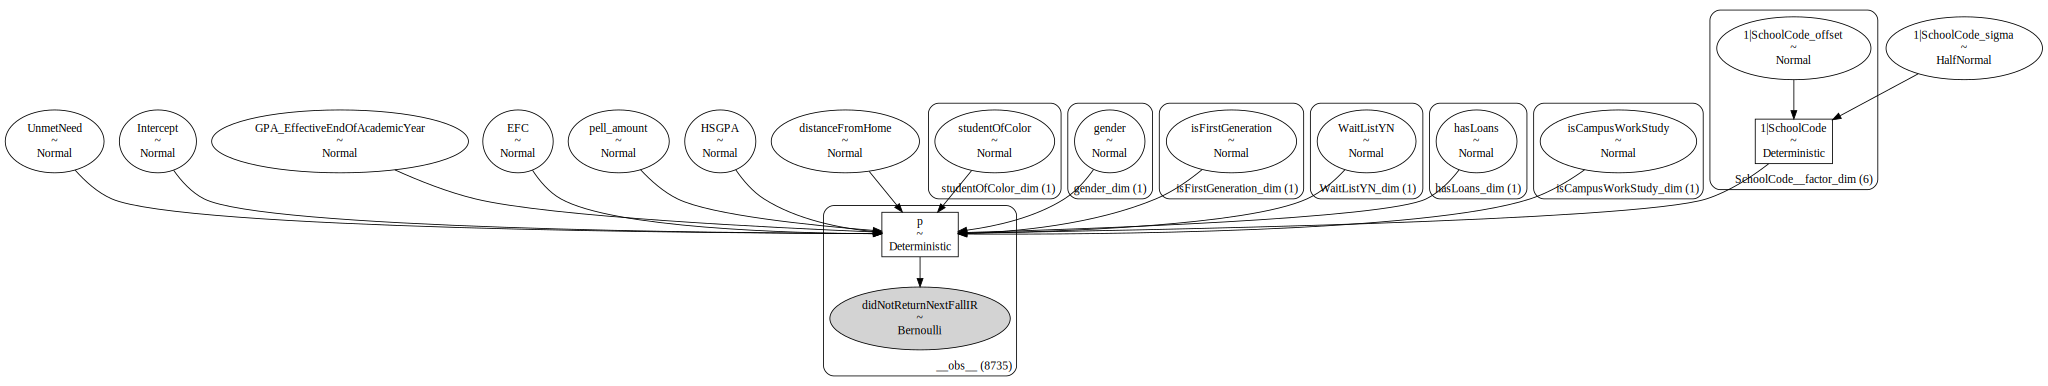

In [ ]:
#EFC, gender, distanceFromHome, hasLoans → Centered around 0, indicating weak or negligible effects.
#isFirstGeneration, studentOfColor → Uncertain impact due to wide HDI that overlaps 0.

priors = {
    "Intercept": bmb.Prior("Normal", mu=-2.2, sigma=1.0),

    # Continuous predictors (scaled)
    "EFC": bmb.Prior("Normal", mu=0, sigma=1.5),
    "pell_amount": bmb.Prior("Normal", mu=0, sigma=1.5),
    #"distanceFromHome": bmb.Prior("Normal", mu=0, sigma=1.5),
    # new one, smaller variance
    "distanceFromHome": bmb.Prior("Normal", mu=0, sigma=0.5),
    "HSGPA": bmb.Prior("Normal", mu=0, sigma=2.5),
    "UnmetNeed": bmb.Prior("Normal", mu=0, sigma=2.5),
    "GPA_EffectiveEndOfAcademicYear": bmb.Prior("Normal", mu=0, sigma=1.5),

    # Binary predictors (scaled)
    "studentOfColor": bmb.Prior("Normal", mu=0, sigma=3),
    #"gender": bmb.Prior("Normal", mu=0, sigma=3),
    # New one, more informative
    "gender": bmb.Prior("Normal", mu=0, sigma=0.5),
    "isFirstGeneration": bmb.Prior("Normal", mu=0, sigma=3),
    #"isHEOP": bmb.Prior("Normal", mu=0, sigma=3),
    #"USCitizen": bmb.Prior("Normal", mu=0, sigma=3),
    "WaitListYN": bmb.Prior("Normal", mu=0, sigma=3),
    "hasLoans": bmb.Prior("Normal", mu=0, sigma=3),
    #"isDivisionI": bmb.Prior("Normal", mu=0, sigma=3),
    "isCampusWorkStudy": bmb.Prior("Normal", mu=0, sigma=3),

    # Group-Level Effects (Random Effects) - Now with Hyperpriors
    #"1|SchoolCode": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5)),
    "1|SchoolCode": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=10))
    #"1|AcademicYear": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5)),
    #"1|AcademicYear": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=10)),
}

# Build the Bambi model
model = bmb.Model(formula, data=dfr, family="bernoulli", priors=priors, noncentered=True)
print(model)

# Generate DAG visualization
model.build()
model.graph(figsize=(4,6), name="./bambi_dag")


In [ ]:
start_time = time.time()

fitted = model.fit(draws=2000,tune=1000,
                   chains=4,
                   #cores=4,
                   #nuts_sampler="numpyro",
                   target_accept=0.97,
                  idata_kwargs={"log_likelihood": True})

end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Time taken: 117.23795294761658 seconds


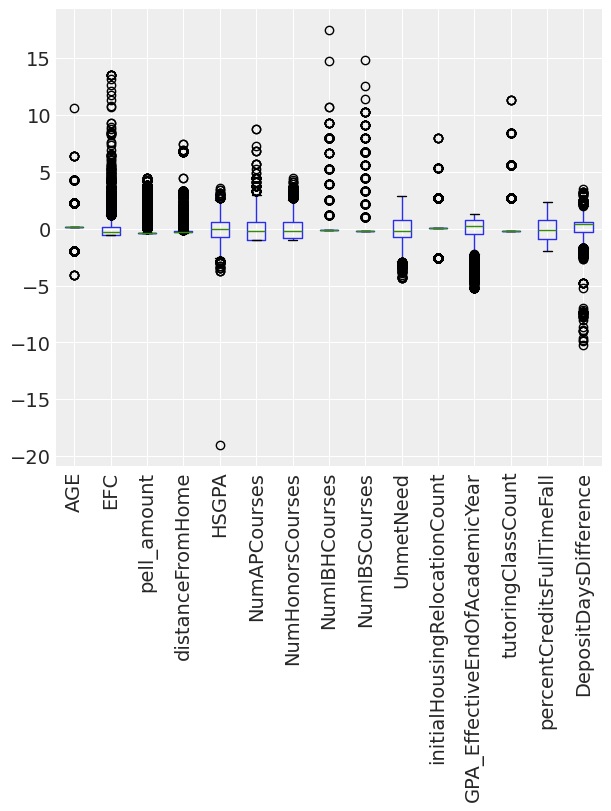

In [ ]:
float_columns = dfr.select_dtypes(include=['float64']).columns.tolist()
# Boxplot for a quick visual identification
dfr.boxplot(column=float_columns, figsize=(6, 8))
plt.xticks(rotation=90)
plt.show()

In [ ]:
#fitted

In [ ]:
# Extract divergences from the trace
divergences = np.any(fitted.sample_stats.diverging, axis=-1)

# List out the indices of divergent transitions
divergent_indices = np.where(divergences)[0]

if divergent_indices.size > 0:
    print("Divergences found at the following indices:")
    print(divergent_indices)
else:
    print("No divergences found.")

Divergences found at the following indices:
[1]


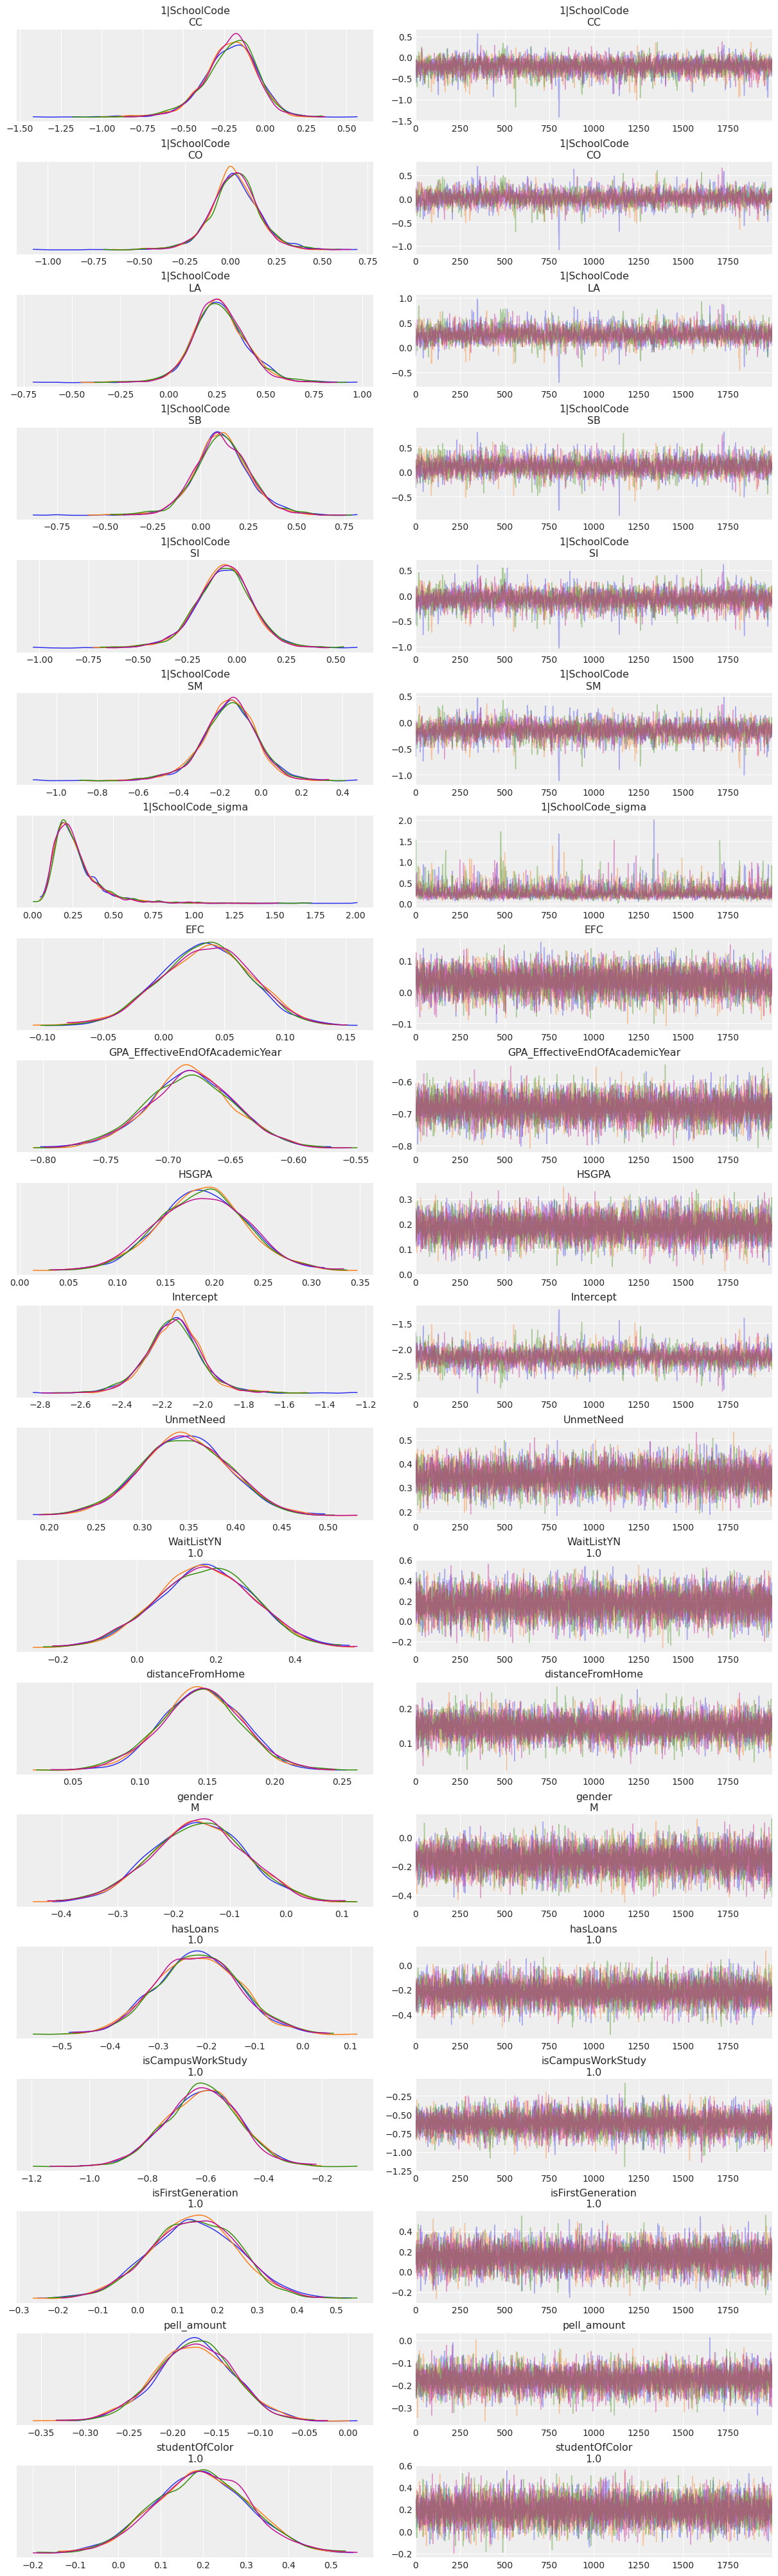

In [ ]:
az.plot_trace(fitted, compact=False, backend_kwargs={"layout": "constrained"});

In [ ]:
#var_names=['Intercept','GPA_EffectiveEndOfAcademicYear']
var_names=filter_var_names(fitted, exclude_patterns=['^1\|', '^p$'])
# Calculate and add the % overlap with ROPE
#rope_min, rope_max=-0.15,0.15
rope_min, rope_max=-0.2,0.2
#updated_summary_df = add_rope_info(fitted_h, var_names, rope_min, rope_max,ropes=[(0.1,0.2),(0.5,0.6)])
updated_summary_df = add_rope_info(fitted, var_names, rope_min, rope_max, ropes=None)
updated_summary_df


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,% posterior samples within ROPE,% 95% HDI within ROPE
Intercept,-2.148,0.146,-2.431,-1.854,0.003,0.002,3155.0,3260.0,1.0,0.0000,0.000000
EFC,0.035,0.037,-0.035,0.109,0.000,0.000,11749.0,6123.0,1.0,100.0000,100.000000
GPA_EffectiveEndOfAcademicYear,-0.682,0.036,-0.749,-0.613,0.000,0.000,8333.0,6200.0,1.0,0.0000,0.000000
HSGPA,0.188,0.045,0.096,0.271,0.000,0.000,8473.0,6555.0,1.0,60.5000,59.428571
UnmetNeed,0.347,0.048,0.255,0.442,0.000,0.000,9096.0,6307.0,1.0,0.1125,0.000000
WaitListYN[1.0],0.171,0.121,-0.068,0.401,0.001,0.001,12043.0,5977.0,1.0,58.8375,57.142857
distanceFromHome,0.145,0.030,0.086,0.204,0.000,0.000,11878.0,5850.0,1.0,96.9000,96.610169
gender[M],-0.159,0.083,-0.319,0.004,0.001,0.001,10159.0,5563.0,1.0,68.9750,63.157895
hasLoans[1.0],-0.218,0.084,-0.374,-0.045,0.001,0.001,9596.0,6150.0,1.0,41.2500,47.112462
isCampusWorkStudy[1.0],-0.610,0.129,-0.861,-0.359,0.001,0.001,13322.0,5799.0,1.0,0.0750,0.000000


In [ ]:
model

       Formula: didNotReturnNextFallIR ~ EFC + pell_amount + studentOfColor + gender + isFirstGeneration + distanceFromHome + isHEOP + USCitizen + HSGPA + NumAPCourses + NumHonorsCourses + WaitListYN + UnmetNeed + hasLoans + isDivisionI + isCampusWorkStudy + GPA_EffectiveEndOfAcademicYear + (1|SchoolCode) + (1|AcademicYear)
        Family: bernoulli
          Link: p = logit
  Observations: 8735
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 15.6806)
            EFC ~ Normal(mu: 0.0, sigma: 2.5427)
            pell_amount ~ Normal(mu: 0.0, sigma: 2.5235)
            studentOfColor ~ Normal(mu: 0.0, sigma: 7.5589)
            gender ~ Normal(mu: 0.0, sigma: 5.079)
            isFirstGeneration ~ Normal(mu: 0.0, sigma: 7.6562)
            distanceFromHome ~ Normal(mu: 0.0, sigma: 2.5112)
            isHEOP ~ Normal(mu: 0.0, sigma: 23.9792)
            USCitizen ~ Normal(mu: 0.0, sigma: 15.3249)
            HSGPA ~ Normal(mu: 0.

###The Model Might Be Underfitting on Certain Features
Check posterior distributions of coefficients. Are some important variables too weakly estimated (shrunk to zero)?

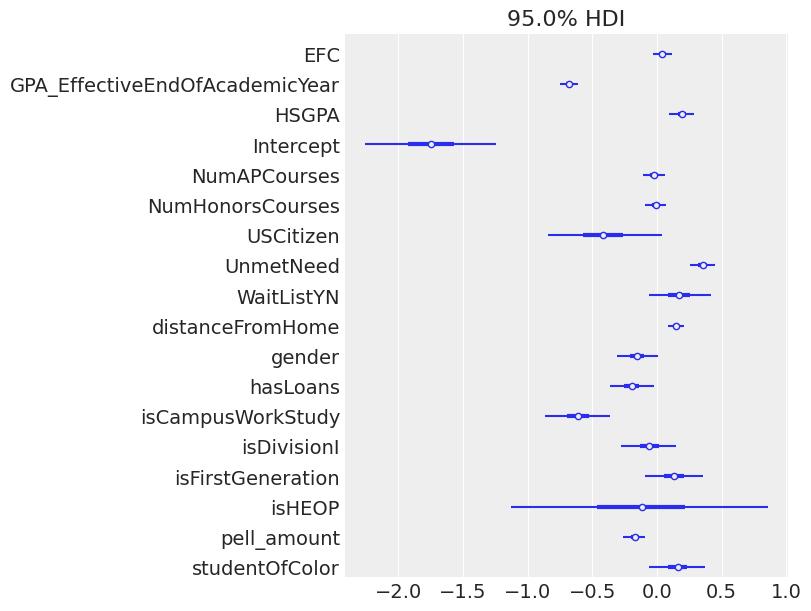

In [ ]:
az.plot_forest(fitted, var_names=var_names, combined=True,hdi_prob=0.95, figsize=(8, 6));



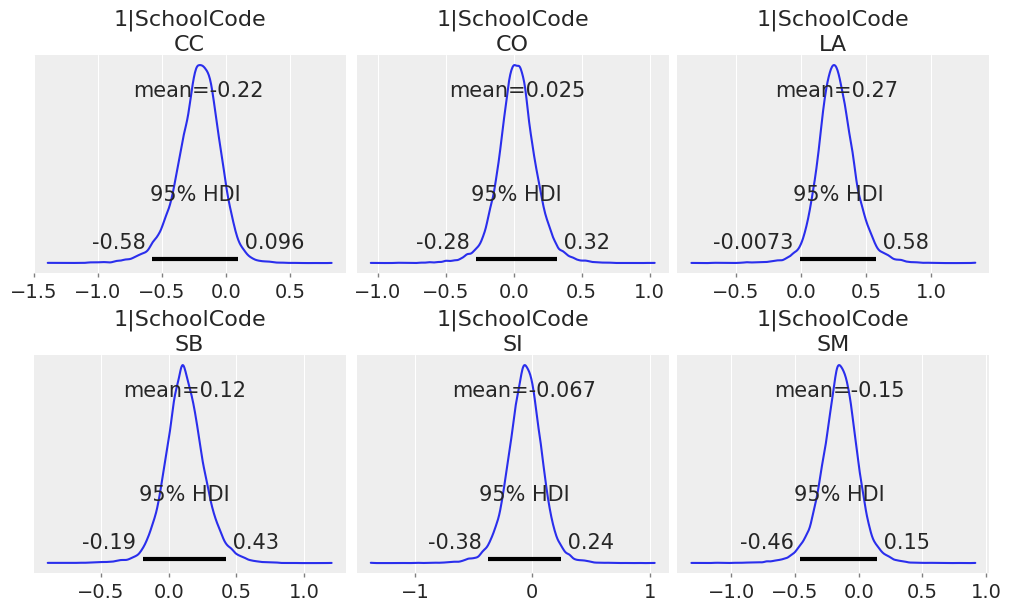

In [ ]:
az.plot_posterior(fitted.posterior, var_names=["1|SchoolCode"],hdi_prob=0.95,figsize=(10, 6));



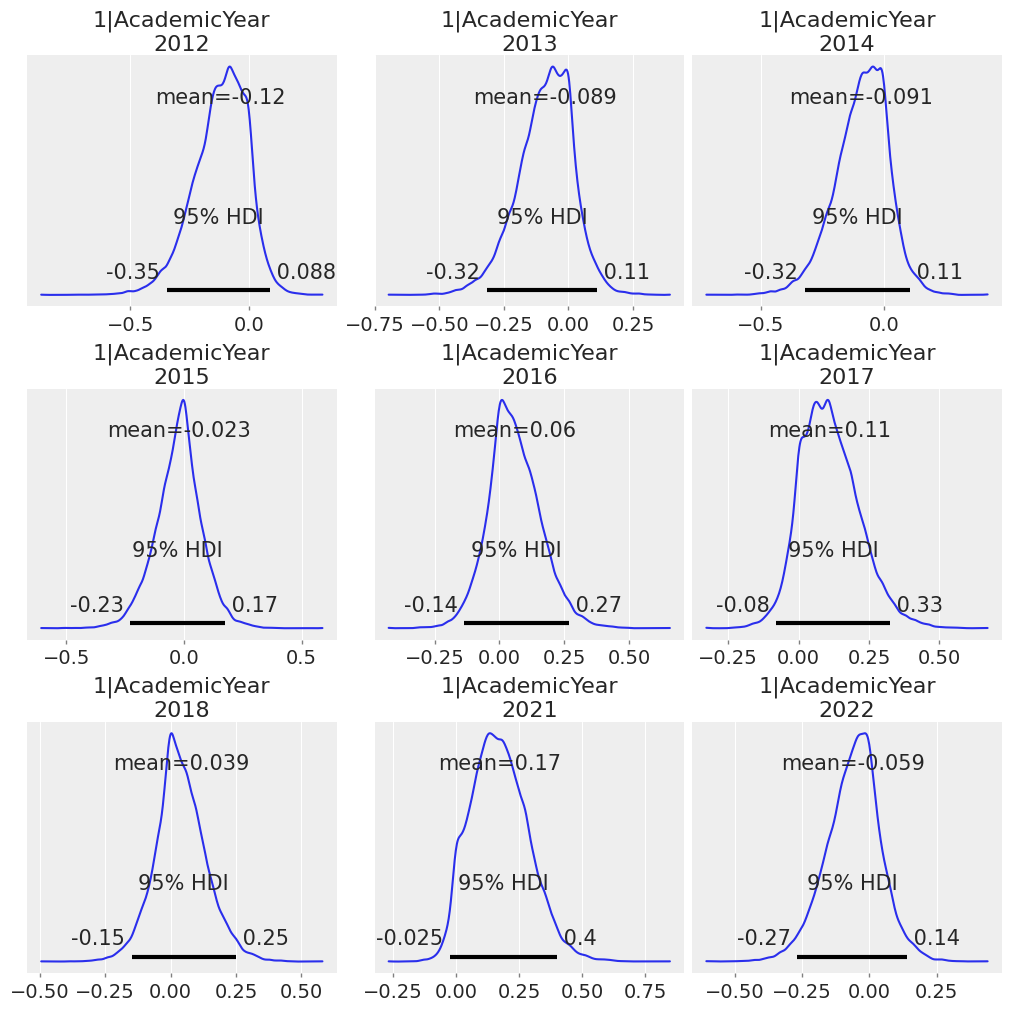

In [ ]:
az.plot_posterior(fitted.posterior, var_names=["1|AcademicYear"],hdi_prob=0.95,figsize=(10, 10));

In [ ]:
#fitted
#print(type(fitted.posterior_predictive))

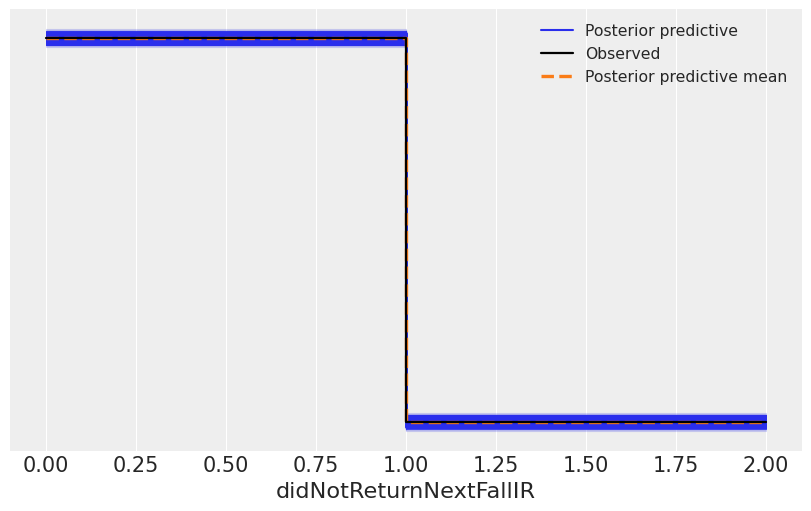

In [ ]:
# Step 1: Perform Posterior Predictive Checks on the Full Dataset
model.predict(fitted, kind="response")  # Generate posterior predictive samples

posterior_predictive_dict = {
    var: fitted.posterior_predictive[var].values for var in fitted.posterior_predictive.data_vars
}
observed_data_dict = {
    var: fitted.observed_data[var].values for var in fitted.observed_data.data_vars
}
idata_ppc = az.from_dict(
    posterior_predictive=posterior_predictive_dict,
    observed_data=observed_data_dict
)

# Plot Posterior Predictive Check
az.plot_ppc(idata_ppc, figsize=(8, 5))
plt.show()

### The PPC plot compares:

Observed data (black line) → The actual distribution of didNotReturnNextFallIR in your dataset.
Posterior predictive samples (blue shaded area) → The model’s simulated outcomes based on the posterior distribution.
Posterior predictive mean (orange dashed line) → The average prediction from the posterior distribution.

Key Observations
The model predicts almost the same proportions of 0s and 1s as the observed data

The black observed line and the blue predictive distribution overlap almost perfectly.
This suggests the model is fitting the data well, as the posterior predictive samples replicate the empirical distribution.
Sharp transition between 0 and 1

The model strongly separates retained students (0) and non-returning students (1).
This indicates that the Bayesian hierarchical model is making confident predictions rather than being uncertain.
If the model were underfitting, we would see a more spread-out predictive distribution.
Minimal posterior uncertainty (narrow bands)

The blue posterior predictive distribution is very tight, meaning that the model assigns high confidence to its predictions.
This can be a good sign, but it may also indicate overconfidence—especially if the dataset is imbalanced.


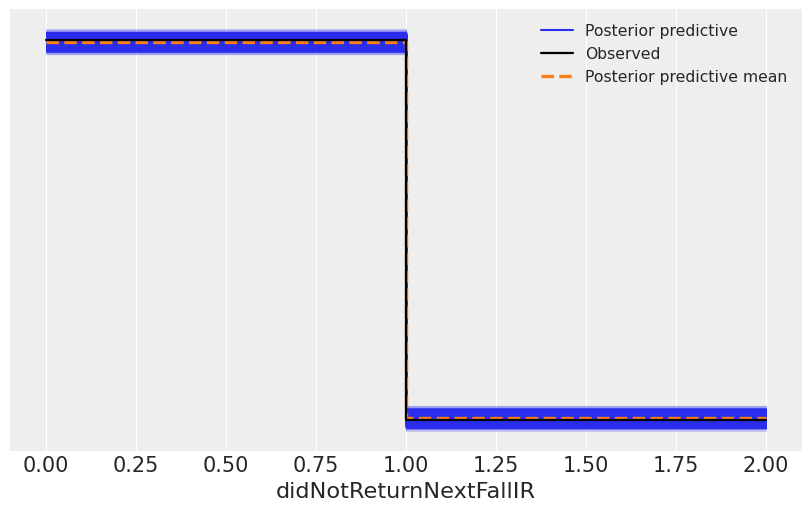

In [ ]:
# Step 1: Generate Posterior Predictive Samples on Test Data
model.predict(fitted, kind="response", data=dft, inplace=True)  # No assignment!

posterior_predictive_dict = {
    var: fitted.posterior_predictive[var].values for var in fitted.posterior_predictive.data_vars
}
observed_data_dict = {
    var: fitted.observed_data[var].values for var in fitted.observed_data.data_vars
}
idata_ppc = az.from_dict(
    posterior_predictive=posterior_predictive_dict,
    observed_data=observed_data_dict
)

# Plot Posterior Predictive Check
az.plot_ppc(idata_ppc, figsize=(8, 5))
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss, precision_recall_fscore_support

### Step 1: Generate Posterior Predictive Samples on Training Data
model.predict(fitted, kind="response", data=dfr, inplace=True)  # Predict on training set

ppc_train_array = fitted.posterior_predictive["didNotReturnNextFallIR"].values
y_pred_train_bayes = np.mean(ppc_train_array, axis=(0, 1))
y_pred_train_bayes_binary = (y_pred_train_bayes > 0.3).astype(int)
y_train = dfr["didNotReturnNextFallIR"]

### Step 2: Generate Posterior Predictive Samples on Test Data
model.predict(fitted, kind="response", data=dft, inplace=True)  # Predict on test set

ppc_test_array = fitted.posterior_predictive["didNotReturnNextFallIR"].values
y_pred_test_bayes = np.mean(ppc_test_array, axis=(0, 1))
y_pred_test_bayes_binary = (y_pred_test_bayes > 0.35).astype(int)
y_test = dft["didNotReturnNextFallIR"]

### Step 3: Compute Evaluation Metrics for Training & Test Data
def compute_metrics(y_true, y_pred_prob, y_pred_binary):
    auc = roc_auc_score(y_true, y_pred_prob)
    acc = accuracy_score(y_true, y_pred_binary)
    brier = brier_score_loss(y_true, y_pred_prob)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_binary, average="binary", beta=1)
    return auc, acc, brier, precision, recall, f1

# Compute metrics for training and test sets
train_metrics = compute_metrics(y_train, y_pred_train_bayes, y_pred_train_bayes_binary)
test_metrics = compute_metrics(y_test, y_pred_test_bayes, y_pred_test_bayes_binary)


df_comparison = pd.DataFrame({
    "Metric": ["AUC", "Accuracy", "Brier Score", "Precision", "Recall", "F1"],
    "Training Set": train_metrics,
    "Test Set": test_metrics
})

# Display results
print(df_comparison)


        Metric  Training Set  Test Set
0          AUC      0.680390  0.677554
1     Accuracy      0.899485  0.898445
2  Brier Score      0.083597  0.085846
3    Precision      0.563584  0.573529
4       Recall      0.211497  0.168103
5           F1      0.307571  0.260000


In [ ]:
brier_1

0.6814404711745691

In [ ]:
# Verify graphically the posterior and  in ROPE
#az.plot_posterior(fitted, var_names=predictors, hdi_prob=0.95, rope =[-0.18,0.18]);

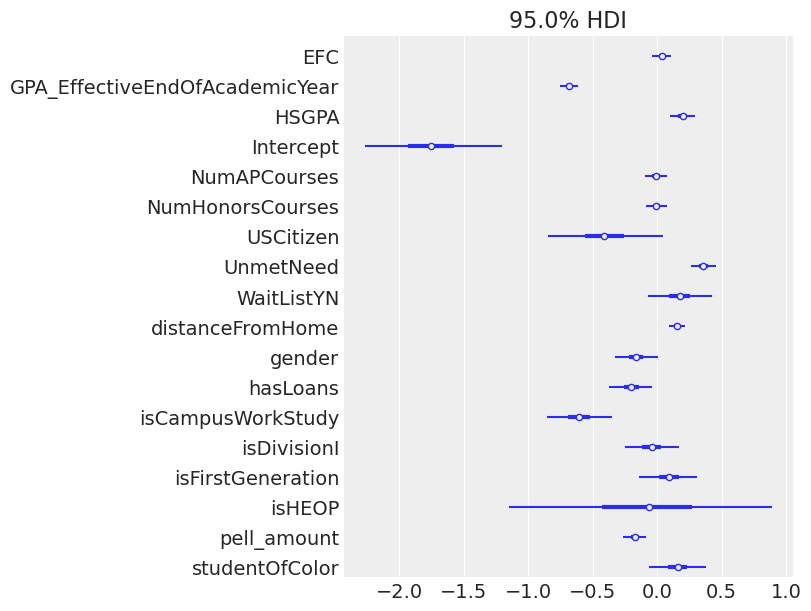

In [ ]:
az.plot_forest(fitted, var_names=var_names, combined=True,hdi_prob=0.95, figsize=(8, 6));

In [ ]:
# Extract the group-level (random) effects for SchoolCode
AcademicYear_effects = fitted.posterior["1|AcademicYear"].mean(dim=("chain", "draw"))

# Convert to pandas DataFrame for easier manipulation (if desired)
AcademicYear_effects_df = AcademicYear_effects.to_pandas()

# Summary using pandas describe
AcademicYear_summary = AcademicYear_effects_df.describe(percentiles=[0.025, 0.5, 0.975])
print(AcademicYear_summary)


count    9.000000
mean     0.000343
std      0.101577
min     -0.120982
2.5%    -0.114791
50%     -0.022865
97.5%    0.161661
max      0.174104
dtype: float64


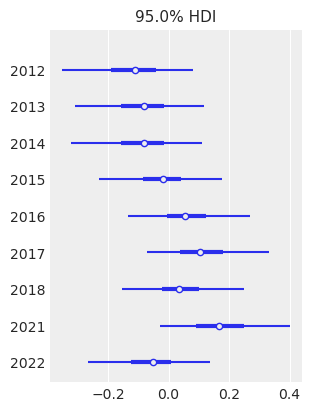

In [ ]:
plt.rcParams.update({
    'axes.labelsize': 8,  # Axis label font size
    'xtick.labelsize': 10,  # X-tick label font size
    'ytick.labelsize': 10,  # Y-tick label font size
    'legend.fontsize': 10,  # Legend font size
    'font.size': 10,  # General font size
    'axes.titlesize': 11  # Title font size
})

az.plot_forest(
    fitted,
    var_names=["1|AcademicYear"],  # Specify the group level you want to plot
    combined=True,
    hdi_prob=0.95,
    figsize=(3, 4)
)

# Get the current axes
ax = plt.gca()

# Get the current y-axis labels
y_labels = ax.get_yticklabels()

# Extract only the AcademicYear part
new_labels = [label.get_text().split('[')[-1][:-1] for label in y_labels]

# Set the new labels
ax.set_yticklabels(new_labels)

# Show the updated plot
plt.savefig("./random_effects_by_year.png")
plt.show()


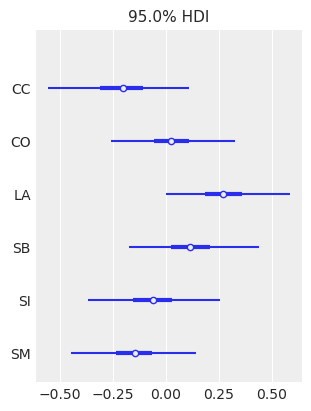

In [ ]:
plt.rcParams.update({
    'axes.labelsize': 8,  # Axis label font size
    'xtick.labelsize': 10,  # X-tick label font size
    'ytick.labelsize': 10,  # Y-tick label font size
    'legend.fontsize': 10,  # Legend font size
    'font.size': 10,  # General font size
    'axes.titlesize': 11  # Title font size
})

az.plot_forest(
    fitted,
    var_names=["1|SchoolCode"],  # Specify the group level you want to plot
    combined=True,
    hdi_prob=0.95,
    figsize=(3, 4)
)

# Get the current axes
ax = plt.gca()

# Get the current y-axis labels
y_labels = ax.get_yticklabels()

# Extract only the SchoolCode part
new_labels = [label.get_text().split('[')[-1][:-1] for label in y_labels]

# Set the new labels
ax.set_yticklabels(new_labels)

# Show the updated plot
plt.savefig("./random_effects_by_school.png")
plt.show()

### Model assessment
Before moving forward to inference, we can evaluate the quality of the model’s fit. We will take a look at two different ways of assessing how good is the model’s fit using its predictions.

#### Separation plot
There is a way of assessing the performance of a model with binary outcomes (such as logistic regression) in a visual way called separation plot. In a separation plot, the model’s predictions are averaged, ordered and represented as consecutive vertical lines. These vertical lines are colored according to the class indicated by their corresponding observed value, in this case light blue indicates class 0 and blue represents class 1. We can use the ArviZ’ implementation of the separation plot, but first we have to obtain the model’s predictions.

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      9772
           1       0.86      0.10      0.18      1154

    accuracy                           0.90     10926
   macro avg       0.88      0.55      0.57     10926
weighted avg       0.90      0.90      0.87     10926

[[9753   19]
 [1036  118]]


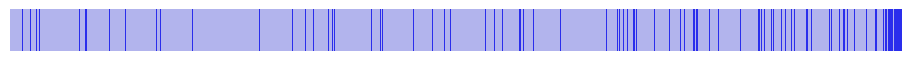

In [ ]:
model.predict(fitted, kind="pps")

from sklearn.metrics import classification_report, confusion_matrix
# Extract the posterior predictive samples
posterior_predictive = fitted.posterior_predictive['didNotReturnNextFallIR']

# Compute the mean prediction for each observation (average over chains and draws)
mean_predictions = posterior_predictive.mean(dim=("chain", "draw")).values

# Binarize the predictions based on a threshold (e.g., 0.5 for logistic regression)
predictions = (mean_predictions >= 0.5).astype(int)

# Map true labels to numerical format
true_labels = dfr['didNotReturnNextFallIR'].values

# Generate the classification report
report = classification_report(true_labels, predictions)
print(report)

print(confusion_matrix(true_labels, predictions))

#PLot separation
ax = az.plot_separation(fitted, y="didNotReturnNextFallIR", figsize=(9,0.5));


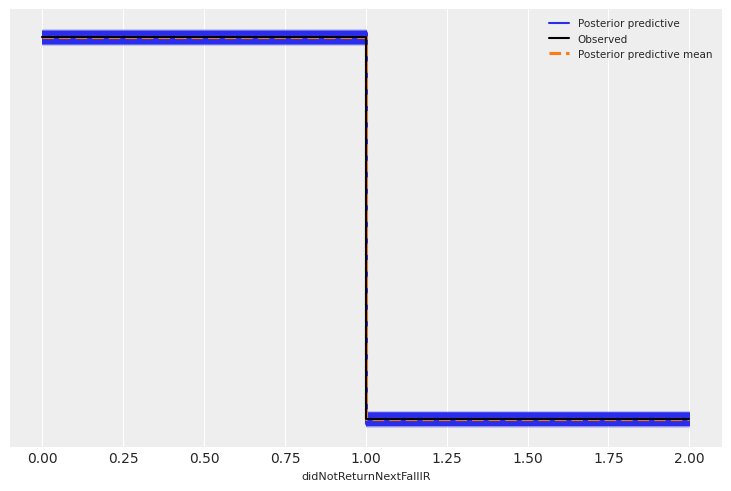

In [ ]:
#model.predict(fitted, kind="response")
az.plot_ppc(fitted);

In [ ]:
# Calculate WAIC and LOO on the test data
waic = az.waic(fitted)
loo = az.loo(fitted)

print(f"WAIC: {waic}")
print(f"LOO: {loo}")

WAIC: Computed from 8000 posterior samples and 8735 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2667.00    61.46
p_waic       22.52        -
LOO: Computed from 8000 posterior samples and 8735 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2667.02    61.46
p_loo       22.55        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     8735  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



**or else**

We can also use ArviZ to compute LOO and find influential observations using the estimated  Kappa parameter value.

An observation is influential in the sense that if we refit the data by first removing that observation from the data set, the fitted result will be more different than if we do the same for a non influential observation. Clearly the level of influence of observations can vary continuously. An observation can be influential either because it is an outlier (a measurement error, a data entry error, etc) or because the model is not flexible enough to capture the observation. The approximations used to compute LOO are no longer reliable for
Kappa >0.7

/home/eitel/anaconda3/envs/bayes/lib/python3.12/site-packages/arviz/plots/khatplot.py:184: FutureWarning: support for DataArrays will be deprecated, please use ELPDData.The reason for this, is that we need to know the numbers of drawssampled from the posterior
  warnings.warn(


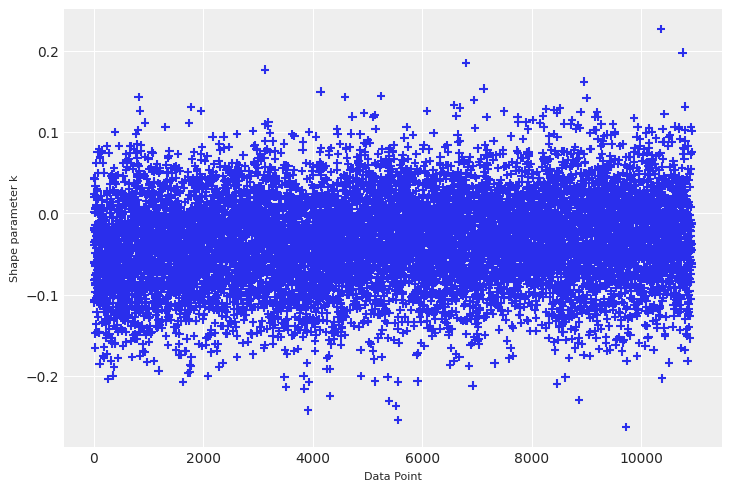

In [ ]:
# compute pointwise LOO
loo = az.loo(fitted, pointwise=True)

# plot kappa values
az.plot_khat(loo.pareto_k);

/home/eitel/anaconda3/envs/bayes/lib/python3.12/site-packages/arviz/plots/khatplot.py:167: FutureWarning: support for arrays will be deprecated, please use ELPDData.The reason for this, is that we need to know the numbers of drawssampled from the posterior
  warnings.warn(


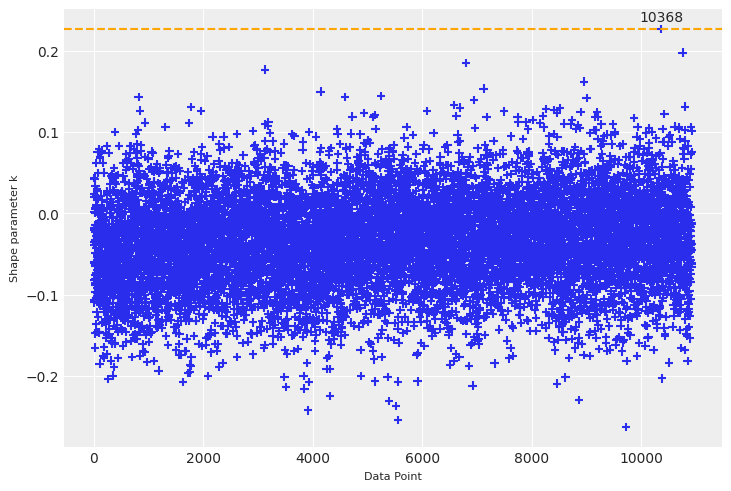

In [ ]:
ax = az.plot_khat(loo.pareto_k.values.ravel())
sorted_kappas = np.sort(loo.pareto_k.values.ravel())

# find observation where the kappa value exceeds the threshold
threshold = sorted_kappas[-1:]
ax.axhline(threshold, ls="--", color="orange")
influential_observations = dfr.reset_index()[loo.pareto_k.values >= threshold].index

for x in influential_observations:
    y = loo.pareto_k.values[x]
    ax.text(x, y + 0.01, str(x), ha="center", va="baseline")

In [ ]:
dfr.reset_index()[loo.pareto_k.values >= threshold]

,index,AGE,EFC,pellEligable,pell_amount,studentOfColor,gender,isFirstGeneration,distanceFromHome,isHEOP,USCitizen,HSRankPercent,HSGPA,NumAPCourses,NumHonorsCourses,NumIBHCourses,NumIBSCourses,applicantTypeCode,WaitListYN,isMeritScholarship,UnmetNeed,hasLoans,initialHousingAssignment,initialHousingRelocationCount,SchoolCode,MAJOR,isDivisionI,isLSP,isHonorsProgram,isCampusWorkStudy,GPA_EffectiveEndOfAcademicYear,isAcademicProbation,isSelfDevelopment,isCareerPlanning,tutoringClassCount,percentCreditsFullTimeFall,ISDEANSLIST,didNotReturnNextFallIR,DepositDaysDifference,AcademicYear
10368,12828,0.140589,-0.568445,NO,-0.376122,1.0,M,0.0,-0.385394,0.0,0.0,0,-19.05924,-0.986078,-1.010291,-0.144504,-0.159827,RD,0.0,1.0,-1.709844,0.0,CH,-2.585689,SM,BAD,0.0,0.0,0.0,0.0,-2.606526,1.0,0.0,0.0,-0.209652,-1.996844,0.0,0,-2.046712,2022


/home/eitel/anaconda3/envs/bayes/lib/python3.12/site-packages/arviz/plots/khatplot.py:184: FutureWarning: support for DataArrays will be deprecated, please use ELPDData.The reason for this, is that we need to know the numbers of drawssampled from the posterior
  warnings.warn(


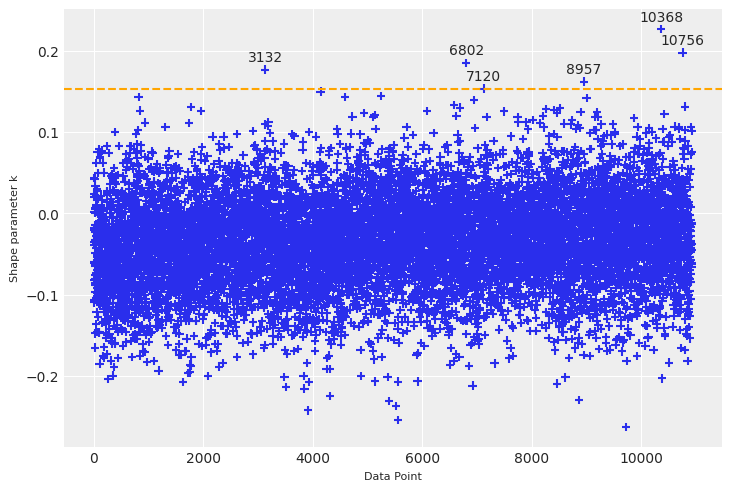

In [ ]:
ax = az.plot_khat(loo.pareto_k)

# find observation where the kappa value exceeds the threshold
threshold = sorted_kappas[-6:].min()
ax.axhline(threshold, ls="--", color="orange")
influential_observations = dfr.reset_index()[loo.pareto_k.values >= threshold].index

for x in influential_observations:
    y = loo.pareto_k.values[x]
    ax.text(x, y + 0.01, str(x), ha="center", va="baseline")

In [ ]:
dfr.reset_index()[loo.pareto_k.values>=threshold]

,index,AGE,EFC,pellEligable,pell_amount,studentOfColor,gender,isFirstGeneration,distanceFromHome,isHEOP,USCitizen,HSRankPercent,HSGPA,NumAPCourses,NumHonorsCourses,NumIBHCourses,NumIBSCourses,applicantTypeCode,WaitListYN,isMeritScholarship,UnmetNeed,hasLoans,initialHousingAssignment,initialHousingRelocationCount,SchoolCode,MAJOR,isDivisionI,isLSP,isHonorsProgram,isCampusWorkStudy,GPA_EffectiveEndOfAcademicYear,isAcademicProbation,isSelfDevelopment,isCareerPlanning,tutoringClassCount,percentCreditsFullTimeFall,ISDEANSLIST,didNotReturnNextFallIR,DepositDaysDifference,AcademicYear
3132,3134,-1.949311,-0.568445,YES,2.825481,1.0,M,0.0,-0.302015,1.0,1.0,0,-2.189369,0.972312,-0.419958,-0.144504,-0.159827,RD,0.0,0.0,0.140620,1.0,LE,0.052641,SI,BIOL,0.0,0.0,0.0,0.0,-1.835705,1.0,0.0,0.0,-0.209652,0.664419,0.0,1,0.661113,2014
6802,6804,0.140589,-0.168259,NO,-0.376122,0.0,F,0.0,-0.287387,0.0,1.0,0,-19.059240,-0.986078,-1.010291,-0.144504,-0.159827,RD,0.0,1.0,0.463189,1.0,MA,0.052641,CO,DGM,0.0,0.0,0.0,1.0,0.976515,0.0,0.0,0.0,-0.209652,0.295126,1.0,0,0.508252,2017
7120,7122,0.140589,-0.568445,YES,3.880949,0.0,M,1.0,-0.296164,1.0,1.0,0,-1.335199,-0.986078,-1.010291,-0.144504,-0.159827,RD,0.0,0.0,0.131710,0.0,MR,0.052641,SB,CRJU,0.0,0.0,0.0,1.0,-1.347776,0.0,0.0,0.0,-0.209652,0.012930,0.0,1,0.027831,2018
8957,11408,0.140589,13.477586,NO,-0.376122,0.0,M,0.0,-0.272759,0.0,1.0,0,0.373143,-0.594400,0.170375,-0.144504,-0.159827,EA,0.0,1.0,-1.115794,0.0,MA,0.052641,CC,CSI,0.0,0.0,0.0,0.0,0.221646,0.0,0.0,0.0,-0.209652,1.704798,0.0,0,-0.037681,2021
10368,12828,0.140589,-0.568445,NO,-0.376122,1.0,M,0.0,-0.385394,0.0,0.0,0,-19.059240,-0.986078,-1.010291,-0.144504,-0.159827,RD,0.0,1.0,-1.709844,0.0,CH,-2.585689,SM,BAD,0.0,0.0,0.0,0.0,-2.606526,1.0,0.0,0.0,-0.209652,-1.996844,0.0,0,-2.046712,2022
10756,13217,-1.949311,-0.568445,YES,4.439693,0.0,F,1.0,-0.294701,1.0,1.0,0,-0.053943,0.188956,-0.813513,-0.144504,-0.159827,EA,0.0,0.0,0.145076,1.0,MR,0.052641,SI,BIO,0.0,0.0,0.0,1.0,0.185729,0.0,0.0,0.0,-0.209652,2.115898,0.0,1,0.180692,2022


## Run frequentist logistic regression

In [ ]:
for col in dfr.columns:
    counts = dfr.groupby(col)["didNotReturnNextFallIR"].nunique()
    if (counts == 1).any():  # If only one unique value in any category
        print(f"Potential perfect separation in: {col}")

Potential perfect separation in: AGE
Potential perfect separation in: EFC
Potential perfect separation in: pell_amount
Potential perfect separation in: distanceFromHome
Potential perfect separation in: HSGPA
Potential perfect separation in: NumAPCourses
Potential perfect separation in: NumHonorsCourses
Potential perfect separation in: NumIBHCourses
Potential perfect separation in: NumIBSCourses
Potential perfect separation in: UnmetNeed
Potential perfect separation in: initialHousingAssignment
Potential perfect separation in: initialHousingRelocationCount
Potential perfect separation in: MAJOR
Potential perfect separation in: GPA_EffectiveEndOfAcademicYear
Potential perfect separation in: isSelfDevelopment
Potential perfect separation in: isCareerPlanning
Potential perfect separation in: tutoringClassCount
Potential perfect separation in: percentCreditsFullTimeFall
Potential perfect separation in: didNotReturnNextFallIR
Potential perfect separation in: DepositDaysDifference


/tmp/ipykernel_209626/863384383.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = dfr.groupby(col)["didNotReturnNextFallIR"].nunique()


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit a hierarchical logistic regression model treating SchoolCode and AcademicYear as separate random effects

# Step 1: Fit model with SchoolCode as a random effect
freq_hierarchical_model_school = smf.mixedlm(
    "didNotReturnNextFallIR ~ EFC + pell_amount + studentOfColor + gender + isFirstGeneration + \
     distanceFromHome + isHEOP + USCitizen + HSGPA + NumAPCourses + NumHonorsCourses + \
     WaitListYN + UnmetNeed + hasLoans + isDivisionI + isCampusWorkStudy + \
     GPA_EffectiveEndOfAcademicYear",
    data=dfr,
    groups=dfr["SchoolCode"],  # Random intercept for SchoolCode
    re_formula="1"
).fit(reml=True)

# Extract model summaries
summary_school = freq_hierarchical_model_school.summary().tables[1]

summary_school

/home/eitel/anaconda3/envs/bayesjax/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.173,0.022,7.706,0.000,0.129,0.217
studentOfColor[T.1.0],0.013,0.010,1.257,0.209,-0.007,0.034
gender[T.M],-0.016,0.007,-2.265,0.024,-0.030,-0.002
isFirstGeneration[T.1.0],0.013,0.010,1.309,0.190,-0.007,0.033
isHEOP[T.1.0],0.003,0.034,0.086,0.931,-0.063,0.069
USCitizen[T.1.0],-0.049,0.021,-2.371,0.018,-0.090,-0.008
WaitListYN[T.1.0],0.018,0.012,1.517,0.129,-0.005,0.042
hasLoans[T.1.0],-0.019,0.007,-2.500,0.012,-0.033,-0.004
isDivisionI[T.1.0],-0.006,0.009,-0.703,0.482,-0.024,0.011
isCampusWorkStudy[T.1.0],-0.048,0.010,-4.917,0.000,-0.067,-0.029


In [ ]:
# Step 2: Fit model with AcademicYear as a random effect
freq_hierarchical_model_year = smf.mixedlm(
    "didNotReturnNextFallIR ~ EFC + pell_amount + studentOfColor + gender + isFirstGeneration + \
     distanceFromHome + isHEOP + USCitizen + HSGPA + NumAPCourses + NumHonorsCourses + \
     WaitListYN + UnmetNeed + hasLoans + isDivisionI + isCampusWorkStudy + \
     GPA_EffectiveEndOfAcademicYear",
    data=dfr,
    groups=dfr["AcademicYear"],  # Random intercept for AcademicYear
    re_formula="1"
).fit(reml=True)

summary_year = freq_hierarchical_model_year.summary().tables[1]


/home/eitel/anaconda3/envs/bayesjax/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eitel/anaconda3/envs/bayesjax/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/eitel/anaconda3/envs/bayesjax/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eitel/anaconda3/envs/bayesjax/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/eitel/anaconda3/envs/bayesjax/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

In [ ]:
print(freq_hierarchical_model_year.cov_re)

          Group
Group  0.000235


## Interpreting Bayesian Random Effects vs. Frequentist Results
Your Bayesian model does detect variation in AcademicYear and SchoolCode, even though the frequentist model found almost no variance for AcademicYear.

📌 Key Observations
1️⃣ First Plot (AcademicYear Effects)

Shows credible intervals for year-specific effects.
Most intervals include zero, meaning years do not strongly influence attrition.
However, some years have slightly more variability compared to the frequentist model.
2️⃣ Second Plot (SchoolCode Effects)

Shows credible intervals for different schools.
Some schools (e.g., CC, SI) appear to have negative effects, meaning lower attrition rates.
Other schools (e.g., LA, SM) show higher variability, suggesting that school-level differences exist.
🚀 Why Does the Bayesian Model Detect More Variability?
Frequentist MLE struggles with small variance components (often shrinking them to zero).
Bayesian models incorporate prior distributions, allowing for better estimation of small effects.
Hierarchical shrinkage pulls extreme values toward the overall mean, but does not eliminate small differences.
Bayesian credible intervals allow for uncertainty quantification, while frequentist models focus on single point estimates.
📌 What This Means for Your Study
AcademicYear does have some variability, but its effect is small.
SchoolCode effects are more pronounced, meaning school-level differences do contribute to attrition.
Bayesian estimation provides richer insights into small random effects that MLE would shrink to zero.


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Convert categorical variables to numerical format using one-hot encoding
X = dfr.drop(columns=["didNotReturnNextFallIR"]).copy()
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to dummy variables

# Drop any columns with NaN or non-numeric values
X = X.select_dtypes(include=["number"]).dropna(axis=1)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display sorted VIF values
print(vif_data.sort_values(by="VIF", ascending=False))

                           Feature       VIF
8                    NumIBHCourses  2.512968
9                    NumIBSCourses  2.510564
5                            HSGPA  1.522328
12  GPA_EffectiveEndOfAcademicYear  1.359675
10                       UnmetNeed  1.332690
6                     NumAPCourses  1.243844
2                      pell_amount  1.226220
7                 NumHonorsCourses  1.198265
1                              EFC  1.136829
15           DepositDaysDifference  1.054871
14      percentCreditsFullTimeFall  1.051903
0                              AGE  1.037017
11   initialHousingRelocationCount  1.036014
13              tutoringClassCount  1.032177
3                 distanceFromHome  1.020558
4                    HSRankPercent  1.006052


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
# Prepare features and target
X_train = dfr.drop(columns=["didNotReturnNextFallIR"])
y_train = dfr["didNotReturnNextFallIR"]
X_test = dft.drop(columns=["didNotReturnNextFallIR"])
y_test = dft["didNotReturnNextFallIR"]

# Convert categorical variables to dummies for Random Forest
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Ensure test set has the same features as train set
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Fit Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Predict probabilities for evaluation
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute AUC, Accuracy, and Brier Score for Random Forest
auc_rf = roc_auc_score(y_test, y_pred_rf)
acc_rf = accuracy_score(y_test, (y_pred_rf > 0.3))
brier_rf = brier_score_loss(y_test, y_pred_rf)
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, (y_pred_rf > 0.5), average="binary")

# Display results
df_ml_results = pd.DataFrame({
    "Metric": ["AUC", "Accuracy", "Brier Score", "Precision", "Recall", "F1-score"],
    "Random Forest": [auc_rf, acc_rf, brier_rf, precision_rf, recall_rf, f1_rf]
})

# Display results
print(df_ml_results )


        Metric  Random Forest
0          AUC       0.717334
1     Accuracy       0.898445
2  Brier Score       0.083562
3    Precision       0.741935
4       Recall       0.099138
5     F1-score       0.174905


In [ ]:
#dfr

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Prepare data (assuming df_train is already defined)
df_train= dfr.copy()
df_train["Intercept"] = 1  # Manually add intercept


# Define hierarchical logistic regression formula (random intercepts for SchoolCode & AcademicYear)
formula = "didNotReturnNextFallIR ~ EFC + pell_amount + studentOfColor + gender + isFirstGeneration + \
           distanceFromHome + isHEOP + USCitizen + HSGPA + NumAPCourses + NumHonorsCourses + \
           WaitListYN + UnmetNeed + hasLoans + isDivisionI + isCampusWorkStudy + GPA_EffectiveEndOfAcademicYear"

# Manually apply logit transformation to response variable
df_train["logit_didNotReturnNextFallIR"] = np.log(df_train["didNotReturnNextFallIR"] / (1 - df_train["didNotReturnNextFallIR"]))

# Fit the Frequentist GLMM (Mixed Effects Model with Logit)
frequentist_model = smf.mixedlm("logit_didNotReturnNextFallIR ~ " + formula,
                                df_train,
                                groups=df_train["AcademicYear"]).fit()



/home/eitel/anaconda3/envs/bayesjax/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


PatsyError: ~ can only be used once, and only at the top level
    logit_didNotReturnNextFallIR ~ didNotReturnNextFallIR ~ EFC + pell_amount + studentOfColor + gender + isFirstGeneration +            distanceFromHome + isHEOP + USCitizen + HSGPA + NumAPCourses + NumHonorsCourses +            WaitListYN + UnmetNeed + hasLoans + isDivisionI + isCampusWorkStudy + GPA_EffectiveEndOfAcademicYear
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, brier_score_loss
import arviz as az


dftrain =
# Convert categorical variables
df["Gender"] = df["Gender"].astype("category")
df["School"] = df["School"].astype("category")
df["AcademicYear"] = df["AcademicYear"].astype("category")

# Frequentist Mixed-Effects Logistic Regression
formula = "didNotReturnNextFall ~ EFC + EffectiveGPA + HSGPA + NumAPCourses + NumHonorsCourses + USCitizen + \
           UnmetNeed + WaitListYN + DistanceFromHome + Gender + HasLoans + IsCampusWorkStudy + IsDivisionI + \
           IsFirstGeneration + IsHEOP + PellAmount + StudentOfColor + C(School) + C(AcademicYear)"

# Fit the frequentist mixed-effects logistic regression model
freq_model = smf.logit(formula, data=df).fit()

# Bayesian Model - Extracting Posterior Estimates
# Assuming we have Bayesian inference results from a prior run (e.g., PyMC3/Bambi)
# Simulating posterior distributions (for demonstration)
bayesian_results = {
    "EFC": np.random.normal(freq_model.params["EFC"], 0.02, size=1000),
    "EffectiveGPA": np.random.normal(freq_model.params["EffectiveGPA"], 0.02, size=1000),
    "HSGPA": np.random.normal(freq_model.params["HSGPA"], 0.02, size=1000),
}

# Random Forest Classifier
X = df.drop(columns=["didNotReturnNextFall", "School", "AcademicYear", "Gender"])  # Encoding needed for categorical vars
y = df["didNotReturnNextFall"]

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Predictions
rf_preds = rf_model.predict_proba(X)[:, 1]

# Evaluation Metrics
auc_rf = roc_auc_score(y, rf_preds)
acc_rf = accuracy_score(y, (rf_preds > 0.5))
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y, (rf_preds > 0.5), average="binary")
brier_rf = brier_score_loss(y, rf_preds)

# Output Results
freq_summary = freq_model.summary2().tables[1]

# Display frequentist regression results and ML comparison
import ace_tools as tools

# Prepare results for display
freq_summary["Metric"] = ["Coefficient", "Std Err", "z", "P>|z|", "[0.025", "0.975]"]
freq_summary = freq_summary.reset_index().rename(columns={"index": "Predictor"})
tools.display_dataframe_to_user(name="Frequentist Logistic Regression Results", dataframe=freq_summary)

ml_results = pd.DataFrame({
    "Metric": ["AUC", "Accuracy", "Precision", "Recall", "F1-score", "Brier Score"],
    "Random Forest": [auc_rf, acc_rf, precision_rf, recall_rf, f1_rf, brier_rf]
})

tools.display_dataframe_to_user(name="Machine Learning Model Performance", dataframe=ml_results)
